In [1]:
# all codes come are changed based on LDR code.
import argparse
import torch.optim as optim
import os
import yaml
from mcrgan.default import _C as config
from mcrgan.default import update_config
import torch
from mcrgan.trainer import MCRTrainer
from mcrgan.datasets import get_dataloader
from mcrgan.models import get_models
from mcrgan.models import get_BNN_models
from mcrgan.models import get_noise
from mcrgan.models import DiscriminatorMNIST
from mcrgan.models import weights_init_mnist_model_noise

import numpy as np
import torch
import argparse
from mcrgan.datasets import get_dataloader
from mcrgan.models import get_models
from mcrgan.default import _C as config
from mcrgan.default import update_config
from utils.utils import sort_dataset, compute_accuracy, extract_features
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from tqdm import tqdm
import os
from mcrgan.loss import MCRGANloss
import random
#random.seed(0)

In [2]:
# data_preprocessing and parameters

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
DATASET = 'FMNIST'
ROOT    = 'pth/to/the/dataset'
BATCH_SIZE = 2048
WORKERS = 0
DATA_SAMPLE = 50000
LABEL = 0

dataloader, dataset = get_dataloader(
        data_name=DATASET,
        root=ROOT,
        batch_size=BATCH_SIZE,
        num_workers=WORKERS)


In [3]:
import collections

def get_netG(netD,netV,net_noise,radius=1):
    models = [netD, netV,net_noise]
    worker_state_dict = [x.state_dict() for x in models]
    weight_keys = list(worker_state_dict[0].keys())
    fed_state_dict = collections.OrderedDict()
    for key in weight_keys:
        fed_state_dict[key] = worker_state_dict[0][key] + radius*worker_state_dict[2][key]*torch.log(1+torch.exp(worker_state_dict[1][key]))
    return fed_state_dict

# new netG already optimized by adam and time learning rate, so we only using netG to update netV
def update_netV(netV,netG,net_noise,fed_state_dict,radius=1):
    models =[netV,netG,net_noise]
    worker_state_dict = [x.state_dict() for x in models]
    weight_keys = list(worker_state_dict[0].keys())
    update_dict = collections.OrderedDict()
    for key in weight_keys:
        update_dict[key] = worker_state_dict[0][key] - (worker_state_dict[1][key]-fed_state_dict[key])*(worker_state_dict[2][key]*radius)/torch.log(1+torch.exp(-worker_state_dict[0][key]))
    return update_dict
        

In [4]:
#models
# train hyperparameters, batch norm not used var
#store_Var = []
import time
from torch_mimicry.training import scheduler, logger, metric_log

from test_acc import nearsub
import numpy as np
import torch
import argparse
from mcrgan.datasets import get_dataloader
from mcrgan.models import get_models
from mcrgan.default import _C as config
from mcrgan.default import update_config
from utils.utils import sort_dataset, compute_accuracy, extract_features2
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from tqdm import tqdm
import os

start_time = time.time()
#global_step = 0
num_steps = 500
n_dis = 1
n_dis2 = 1
numclasses =10
lr1 = 1e-3
lr2 = 1e-3
log_data = metric_log.MetricLog()
data_time = time.time()
iter_dataloader = iter(dataloader)
data, label = next(iter_dataloader)
data_time = time.time() - data_time
real_cpu = data.to(device)
real_label = label.clone().detach()

netD, netG, netV = get_BNN_models(DATASET, device, LABEL)
net_noise = get_noise(DATASET, device, LABEL)
fed_state_dict = get_netG(netD,netV,net_noise)
netG.load_state_dict(fed_state_dict)
optD = optim.Adam(netD.parameters(), lr1, betas=(0.5, 0.999))
optG = optim.Adam(netG.parameters(), lr2, betas=(0.5, 0.999))

Acc_results_D = []
Acc_results_G = []




transform = transforms.Compose(
            [transforms.Resize(32),
             transforms.ToTensor(),
             transforms.Normalize(0.5, 0.5)])

trainset = datasets.FashionMNIST(root=ROOT, train=True, download=True, transform=transform)
testset = datasets.FashionMNIST(root=ROOT, train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(
        testset, batch_size=DATA_SAMPLE, shuffle=False, num_workers=WORKERS)

trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=DATA_SAMPLE, shuffle=False, num_workers=WORKERS)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
n_comp = 10


In [5]:
netD, netG, netV

(DataParallel(
   (module): DiscriminatorMNIST(
     (main): Sequential(
       (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): LeakyReLU(negative_slope=0.2, inplace=True)
       (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (3): LeakyReLU(negative_slope=0.2, inplace=True)
       (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (5): LeakyReLU(negative_slope=0.2, inplace=True)
       (6): Conv2d(256, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
       (7): Flatten(start_dim=1, end_dim=-1)
     )
   )
 ),
 DataParallel(
   (module): DiscriminatorMNIST(
     (main): Sequential(
       (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): LeakyReLU(negative_slope=0.2, inplace=True)
       (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (3): LeakyReLU(negative_slope=0.2,

In [6]:
net_noise

DataParallel(
  (module): DiscriminatorMNIST(
    (main): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
      (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (5): LeakyReLU(negative_slope=0.2, inplace=True)
      (6): Conv2d(256, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (7): Flatten(start_dim=1, end_dim=-1)
    )
  )
)

In [7]:
# golden search algorithm to determined the radius of the sample ball, due to traditional updating netV is too slow
# no meaning for n_dis =2 for our case, just to have output for every update
# sample too much would arise cuda memory error
def gs_radius(radius1,radius2,netD,real_cpu,real_label,tor=1e-3,n_dis=2,lam=0.618,mode=1,gam3=1):
    mcr_gan_loss=MCRGANloss(gam1=1., gam2=1., gam3=gam3, eps=0.5, numclasses=numclasses, mode=11, rho=None)
    #optG = optim.Adam(netG.parameters(), lr2, betas=(0.5, 0.999))
    
    Z = netD(real_cpu)
    net_noise = get_noise(DATASET, device, LABEL)
    err1 = 0
    err2 = 1000
    while abs(err1 - err2)> tor or abs(radius1-radius2)>tor:
        a1 = radius2 - lam*(radius2-radius1)
        a2 = radius1 + lam*(radius2-radius1)
        fed_state_dict = get_netG(netD,netV,net_noise,a1)
        netG.load_state_dict(fed_state_dict)
        Z_bar = netG(real_cpu)
        errG1, errG_EC1 = mcr_gan_loss(Z, Z_bar, real_label, n_dis2 - 1, n_dis2)
        err1 = errG1
        
        fed_state_dict = get_netG(netD,netV,net_noise,a2)
        netG.load_state_dict(fed_state_dict)
        Z_bar = netG(real_cpu)
        errG2, errG_EC2 = mcr_gan_loss(Z, Z_bar, real_label, n_dis2 - 1, n_dis2)
        err2 = errG2
        
        if err1 > err2:
            radius1 = a1
            a1 = a2
            err1 = err2
            a2 = radius1 + lam*(radius2-radius1)
            fed_state_dict = get_netG(netD,netV,net_noise,a2)
            netG.load_state_dict(fed_state_dict)
            Z_bar = netG(real_cpu)
            errG2, errG_EC2 = mcr_gan_loss(Z, Z_bar, real_label, n_dis2 - 1, n_dis2)
            err2 = errG2
            #print('r1',radius1)
            #print(errG2, errG_EC2)
        else:
            radius2 = a2
            a2 = a1
            a1 = radius2 - lam*(radius2-radius1)
            fed_state_dict = get_netG(netD,netV,net_noise,a1)
            netG.load_state_dict(fed_state_dict)
            Z_bar = netG(real_cpu)
            errG1, errG_EC1 = mcr_gan_loss(Z, Z_bar, real_label, n_dis2 - 1, n_dis2)
            err1 = errG1
            #print('r2',radius2)
            #print(errG1, errG_EC1)
         
    return radius1,radius2

In [8]:
# golden search algorithm to determined the radius of the sample ball, due to traditional updating netV is too slow
# no meaning for n_dis =2 for our case, just to have output for every update
# sample too much would arise cuda memory error
def gs_radius_val(radius1,radius2,netD,real_cpu,real_label,tor=1e-3,n_dis=2,lam=0.618,mode=1,gam3=1):
    mcr_gan_loss=MCRGANloss(gam1=1., gam2=1., gam3=gam3, eps=0.5, numclasses=numclasses, mode=11, rho=None)
    #optG = optim.Adam(netG.parameters(), lr2, betas=(0.5, 0.999))
    n_comp = 10
    Z = netD(real_cpu)
    net_noise = get_noise(DATASET, device, LABEL)
    err1 = 0
    err2 = 1000
    while abs(err1 - err2)> tor or abs(radius1-radius2)>tor:
        a1 = radius2 - lam*(radius2-radius1)
        a2 = radius1 + lam*(radius2-radius1)
        fed_state_dict = get_netG(netD,netV,net_noise,a1)
        netG.load_state_dict(fed_state_dict)
        Z_bar = netG(real_cpu)
        errG1, errG_EC1 = mcr_gan_loss(Z, Z_bar, real_label, n_dis2 - 1, n_dis2)
        err1 = errG1
        
        fed_state_dict = get_netG(netD,netV,net_noise,a2)
        netG.load_state_dict(fed_state_dict)
        Z_bar = netG(real_cpu)
        errG2, errG_EC2 = mcr_gan_loss(Z, Z_bar, real_label, n_dis2 - 1, n_dis2)
        err2 = errG2
        
        if err1 > err2:
            radius1 = a1
            a1 = a2
            err1 = err2
            a2 = radius1 + lam*(radius2-radius1)
            fed_state_dict = get_netG(netD,netV,net_noise,a2)
            netG.load_state_dict(fed_state_dict)
            Z_bar = netG(real_cpu)
            errG2, errG_EC2 = mcr_gan_loss(Z, Z_bar, real_label, n_dis2 - 1, n_dis2)
            err2 = errG2
            #print('r1',radius1)
            #print(errG2, errG_EC2)
        else:
            radius2 = a2
            a2 = a1
            a1 = radius2 - lam*(radius2-radius1)
            fed_state_dict = get_netG(netD,netV,net_noise,a1)
            netG.load_state_dict(fed_state_dict)
            Z_bar = netG(real_cpu)
            errG1, errG_EC1 = mcr_gan_loss(Z, Z_bar, real_label, n_dis2 - 1, n_dis2)
            err1 = errG1
            #print('r2',radius2)
            #print(errG1, errG_EC1)
            
    fed_state_dict = get_netG(netD,netV,net_noise,radius1)
    netG.load_state_dict(fed_state_dict)
    Z_bar = netG(real_cpu)
    
    
    corr_mean = np.zeros([n_comp,n_comp])
    corr_abs_mean = np.zeros([n_comp,n_comp])
    corr_min  = np.zeros([n_comp,n_comp])
    corr_max  = np.zeros([n_comp,n_comp])

    for i in range(10):
        for j in range(10):
            if i >= j :
                # change to 150 fit FMNIST data
                similarity_matrix = torch.nn.functional.cosine_similarity(Z_bar[label==i][0:150], Z_bar[label==j][0:150])
                temp_mean = torch.mean(similarity_matrix)
                temp_min = torch.min(similarity_matrix)
                temp_max = torch.max(similarity_matrix)
                temp_abs_mean = torch.mean(abs(similarity_matrix))

                corr_mean[i][j] = temp_mean
                corr_abs_mean[i][j] = temp_abs_mean
                corr_min[i][j]  = temp_min
                corr_max[i][j]  = temp_max

                corr_mean[j][i] = corr_mean[i][j]
                corr_abs_mean[j][i] = corr_abs_mean[i][j]
                corr_min[j][i] = corr_min[i][j]
                corr_max[j][i] = corr_max[i][j]
                
    corr_whole = np.zeros([4*n_comp,n_comp])
    corr_whole[0:10][:] =  corr_mean
    corr_whole[10:20][:] = corr_abs_mean
    corr_whole[20:30][:] = corr_min
    corr_whole[30:40][:] = corr_max
    
    
    fed_state_dict = get_netG(netD,netV,net_noise,radius1)
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    acc_val = count/10000
    print('NetG_fixDwith radius',radius1,acc_val)

         
    return radius1,radius2,corr_whole,acc_val

In [9]:
# fixed radius case, due to this requires more steps to go to about -200 then set 1500 epoches
mean_V = []
n_dis2 = 1
n_dis = 1
mode = 1
gam3 = 1
mcr_gan_loss = MCRGANloss(gam1=1., gam2=1., gam3=gam3, eps=0.5, numclasses=numclasses, mode=mode, rho=None)
loss_V = 0
last_V = -1000
num_steps = 500
lr1 = 1e-3
lr2 = 1e-3
optD = optim.Adam(netD.parameters(), lr1, betas=(0.5, 0.999))
optG = optim.Adam(netG.parameters(), lr2, betas=(0.5, 0.999))
meanV_sum = []
radius_list = []
radius = 0
for epoch in range(num_steps):

    for i in range(n_dis):
        netD.zero_grad()
        optD.zero_grad()
        Z = netD(real_cpu)
        net_noise = get_noise(DATASET, device, LABEL)
        #radius,_ = gs_radius(radius1=0,radius2=100,netD=netD,real_cpu=real_cpu,real_label=real_label,tor=1e-5,n_dis=2,lam=0.618,mode=1)
        #radius_list.append(radius)
        #print(radius)
        fed_state_dict = get_netG(netD,netV,net_noise,radius)
        netG.load_state_dict(fed_state_dict)
        Z_bar = netG(real_cpu)
        errD, errD_EC = mcr_gan_loss(Z, Z_bar, real_label, 1, n_dis)
        print(errD, errD_EC)
        errD.backward()
        optD.step()

    #print(meanV_num)
    #print(tempV)
    
    

tensor(-11.3438, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-5.6719, device='cuda:0', grad_fn=<NegBackward0>), tensor(-5.6719, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-7.3516, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-3.6758, device='cuda:0', grad_fn=<NegBackward0>), tensor(-3.6758, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-16.0670, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-8.0335, device='cuda:0', grad_fn=<NegBackward0>), tensor(-8.0335, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-20.1274, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-10.0637, device='cuda:0', grad_fn=<NegBackward0>), tensor(-10.0637, device='cuda:0', grad_fn=<NegBackward0>), tensor(1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-23.0611, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-11.5305, dev

tensor(-63.4899, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-31.7450, device='cuda:0', grad_fn=<NegBackward0>), tensor(-31.7450, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-64.2383, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-32.1191, device='cuda:0', grad_fn=<NegBackward0>), tensor(-32.1191, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-64.7104, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-32.3552, device='cuda:0', grad_fn=<NegBackward0>), tensor(-32.3552, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-64.8128, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-32.4064, device='cuda:0', grad_fn=<NegBackward0>), tensor(-32.4064, device='cuda:0', grad_fn=<NegBackward0>), tensor(-3.0518e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-64.0896, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-32.0

tensor(-74.8364, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-37.4182, device='cuda:0', grad_fn=<NegBackward0>), tensor(-37.4182, device='cuda:0', grad_fn=<NegBackward0>), tensor(-3.0518e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-75.0618, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-37.5309, device='cuda:0', grad_fn=<NegBackward0>), tensor(-37.5309, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-75.9524, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-37.9762, device='cuda:0', grad_fn=<NegBackward0>), tensor(-37.9762, device='cuda:0', grad_fn=<NegBackward0>), tensor(3.0518e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-76.4367, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-38.2184, device='cuda:0', grad_fn=<NegBackward0>), tensor(-38.2184, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-76.9870, device='cuda:0', grad_fn=<NegBackward0>) [tens

tensor(-81.7188, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-40.8594, device='cuda:0', grad_fn=<NegBackward0>), tensor(-40.8594, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-82.0785, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-41.0392, device='cuda:0', grad_fn=<NegBackward0>), tensor(-41.0392, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-83.4288, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-41.7144, device='cuda:0', grad_fn=<NegBackward0>), tensor(-41.7144, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-84.3462, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-42.1731, device='cuda:0', grad_fn=<NegBackward0>), tensor(-42.1731, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-84.3285, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-42.1642, devi

tensor(-87.5024, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-43.7512, device='cuda:0', grad_fn=<NegBackward0>), tensor(-43.7512, device='cuda:0', grad_fn=<NegBackward0>), tensor(-1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-87.0056, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-43.5028, device='cuda:0', grad_fn=<NegBackward0>), tensor(-43.5028, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-86.7430, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-43.3715, device='cuda:0', grad_fn=<NegBackward0>), tensor(-43.3715, device='cuda:0', grad_fn=<NegBackward0>), tensor(-1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-87.5828, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-43.7914, device='cuda:0', grad_fn=<NegBackward0>), tensor(-43.7914, device='cuda:0', grad_fn=<NegBackward0>), tensor(1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-88.3103, device='cuda:0', grad_fn=<NegBackward

tensor(-89.6565, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-44.8283, device='cuda:0', grad_fn=<NegBackward0>), tensor(-44.8283, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-89.9294, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-44.9647, device='cuda:0', grad_fn=<NegBackward0>), tensor(-44.9647, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-90.3929, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-45.1965, device='cuda:0', grad_fn=<NegBackward0>), tensor(-45.1965, device='cuda:0', grad_fn=<NegBackward0>), tensor(-1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-89.7478, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-44.8739, device='cuda:0', grad_fn=<NegBackward0>), tensor(-44.8739, device='cuda:0', grad_fn=<NegBackward0>), tensor(-1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-90.0641, device='cuda:0', grad_fn=<NegBackward0>) [ten

tensor(-92.6793, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-46.3397, device='cuda:0', grad_fn=<NegBackward0>), tensor(-46.3397, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-92.9170, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-46.4585, device='cuda:0', grad_fn=<NegBackward0>), tensor(-46.4585, device='cuda:0', grad_fn=<NegBackward0>), tensor(-1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-93.1255, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-46.5628, device='cuda:0', grad_fn=<NegBackward0>), tensor(-46.5628, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-93.3126, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-46.6563, device='cuda:0', grad_fn=<NegBackward0>), tensor(-46.6563, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-93.3618, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-46.6

tensor(-94.8755, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-47.4377, device='cuda:0', grad_fn=<NegBackward0>), tensor(-47.4377, device='cuda:0', grad_fn=<NegBackward0>), tensor(-3.0518e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-94.8969, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-47.4484, device='cuda:0', grad_fn=<NegBackward0>), tensor(-47.4484, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-94.8922, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-47.4461, device='cuda:0', grad_fn=<NegBackward0>), tensor(-47.4461, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-94.9649, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-47.4824, device='cuda:0', grad_fn=<NegBackward0>), tensor(-47.4824, device='cuda:0', grad_fn=<NegBackward0>), tensor(3.0518e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-94.8996, device='cuda:0', grad_fn=<NegBackward0>) [tens

tensor(-95.3228, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-47.6614, device='cuda:0', grad_fn=<NegBackward0>), tensor(-47.6614, device='cuda:0', grad_fn=<NegBackward0>), tensor(1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-95.6679, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-47.8340, device='cuda:0', grad_fn=<NegBackward0>), tensor(-47.8340, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-96.0426, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-48.0213, device='cuda:0', grad_fn=<NegBackward0>), tensor(-48.0213, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-96.3949, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-48.1974, device='cuda:0', grad_fn=<NegBackward0>), tensor(-48.1974, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-96.5740, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-48.28

tensor(-96.4632, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-48.2316, device='cuda:0', grad_fn=<NegBackward0>), tensor(-48.2316, device='cuda:0', grad_fn=<NegBackward0>), tensor(3.0518e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-96.5616, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-48.2808, device='cuda:0', grad_fn=<NegBackward0>), tensor(-48.2808, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-96.4695, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-48.2347, device='cuda:0', grad_fn=<NegBackward0>), tensor(-48.2347, device='cuda:0', grad_fn=<NegBackward0>), tensor(-3.0518e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-96.0178, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-48.0089, device='cuda:0', grad_fn=<NegBackward0>), tensor(-48.0089, device='cuda:0', grad_fn=<NegBackward0>), tensor(1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-95.5153, device='cuda:0', grad_fn=<NegBackward0

tensor(-97.2470, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-48.6235, device='cuda:0', grad_fn=<NegBackward0>), tensor(-48.6235, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-97.3158, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-48.6579, device='cuda:0', grad_fn=<NegBackward0>), tensor(-48.6579, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-97.5068, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-48.7534, device='cuda:0', grad_fn=<NegBackward0>), tensor(-48.7534, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-97.6401, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-48.8201, device='cuda:0', grad_fn=<NegBackward0>), tensor(-48.8201, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-97.7274, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-48.8637, devi

tensor(-97.1823, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-48.5912, device='cuda:0', grad_fn=<NegBackward0>), tensor(-48.5912, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-97.3794, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-48.6897, device='cuda:0', grad_fn=<NegBackward0>), tensor(-48.6897, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-97.7986, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-48.8993, device='cuda:0', grad_fn=<NegBackward0>), tensor(-48.8993, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-98.0055, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.0028, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.0028, device='cuda:0', grad_fn=<NegBackward0>), tensor(1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-98.1753, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.08

tensor(-98.4638, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.2319, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.2319, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-98.2763, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.1382, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.1382, device='cuda:0', grad_fn=<NegBackward0>), tensor(1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-98.2918, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.1459, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.1459, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-98.5794, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.2897, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.2897, device='cuda:0', grad_fn=<NegBackward0>), tensor(-1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-99.0025, device='cuda:0', grad_fn=<NegBackward0>) [tens

tensor(-99.0216, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.5108, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.5108, device='cuda:0', grad_fn=<NegBackward0>), tensor(-1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-98.9776, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.4888, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.4888, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-99.1098, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.5549, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.5549, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-99.0964, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.5482, device='cuda:0', grad_fn=<NegBackward0>), tensor(-49.5482, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-99.0447, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-49.5

In [10]:
#10/256, 9/1000 for 200 epoches -196.2230, resample again under load case to avoid wrong.
r_records = np.zeros(1000)
for i in range(1000):
    radius_bar,_ = gs_radius(radius1=0,radius2=100,netD=netD,real_cpu=real_cpu,real_label=real_label,tor=1e-5,n_dis=2,lam=0.618,mode=1)
    r_records[i] = radius_bar
    print(radius_bar)

0.1979733732190678
0.18765421630470547
0.18559769676006038
0.19934775971282703
0.18569734285492445
0.1989956434437613
0.17139570975691545
0.1986430893793787
0.19286076853775297
0.17202100459037137
0.17715648175225532
0.19146476152031272
0.17792658555601668
0.18533708761128312
0.19658806862144765
0.171397055985554
0.17944494817019208
0.1980477038296013
0.1764837353778314
0.17400507287365838
0.18920426613329597
0.1933696564770625
0.1974932241146179
0.1923774936720123
0.19165908598131698
0.1922574621283378
0.19743170151340672
0.1963703020865681
0.1898829274518532
0.1877078934309433
0.17567329008524546
0.1905687419390113
0.18614784018458863
0.1894714898879476
0.1850530288202807
0.19929207076125907
0.20731478221197264
0.1899056587440737
0.18959090351687352
0.20103076279023385
0.19053433812413642
0.18077811977293606
0.20301034699602777
0.17681076282325978
0.190544302582476
0.18135001095556144
0.19680278358829267
0.19657233842923993
0.19576397541740753
0.1874472813928719
0.1959828150017205
0.

0.179989648161547
0.18087928650912258
0.19204451324346544
0.16649123301919877
0.19221158211470404
0.18537814419809143
0.19538450198078375
0.19524366353025932
0.16632507344422165
0.18824984697629016
0.18653961605716057
0.17608257562688007
0.18356034997513207
0.19183278960934208
0.1965753915575795
0.19593117307826027
0.18942985559191705
0.18545461569891905
0.18597825205287422
0.18832401638636012
0.20115256870896353
0.1960354106926091
0.20305950081728144
0.17261988269785009
0.19036070771504623
0.1928298566204292
0.20301034699602777
0.18827015355472043
0.19628149554662463
0.1879781748780468
0.1964172883855767
0.19001568227346793
0.19405501426206878
0.1782207927396227
0.16819067235967258
0.18795587640585176
0.19328462340006122
0.18273695195694267
0.1836248486400666
0.2030718632225409
0.1933920042860661
0.1973339247539344
0.18553032271881995
0.1896150153618172
0.19759432175810218
0.1962445868701956
0.19221173983115034
0.1909307096092748
0.20269710400368846
0.20714908702710538
0.1987809030354

0.19377049609562638
0.19971590629366742
0.1828159236575054
0.18284009372555798
0.184444874144789
0.17006847122988988
0.20514267923279253
0.19478904321207144
0.1984917121966207
0.18424863484907214
0.18690746425444427
0.1971837191334862
0.19641915229659085
0.21075098625496486
0.1937298033293904
0.1770050247502304
0.18360135975364694
0.16961319631498045
0.19822142473942073
0.17655803238629958
0.18718668989710363
0.19195515132797747
0.20108929286654928
0.1901537219116631
0.20052090051750598
0.18478574865056951
0.2033988149192049
0.19510119092582728
0.19206206811041893
0.19124529693712614
0.20188391743225925
0.19960668812859936
0.20083831388404125
0.182946956330834
0.19769182272749553
0.19320862991290555
0.18597065762786635
0.19126394800016117
0.18025556379765273
0.19062127509880378
0.1718500825871841
0.18630848753267165
0.19894178061212162
0.20631874989248145
0.202487178949137
0.1858724187727749
0.18536744173162364
0.198333672150702
0.1975614632169528
0.18639995534261417
0.1954936962637254

In [11]:
np.histogram(r_records)

(array([  2,   3,   8,  51, 114, 211, 316, 234,  55,   6], dtype=int64),
 array([0.14286931, 0.15045214, 0.15803496, 0.16561779, 0.17320062,
        0.18078345, 0.18836628, 0.19594911, 0.20353194, 0.21111477,
        0.21869759]))

In [12]:
#acc at first for NetD
NetD_acc = 0
train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(testloader, netD, netG)

test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netD, netG)


print("----------------------------")
print("Train_z, Test_z")
nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

#acc at first for NetD
from sklearn.neighbors import KNeighborsClassifier 
knn= KNeighborsClassifier(n_neighbors=10) 

knn.fit(train_Z,train_labels) 
knn.score(test_Z,test_labels) 
 
y_predict = knn.predict(test_Z) 

count =0
for k in range(10000):
    if y_predict[k] == test_labels[k]:
        count +=1
        
NetD_acc = count/10000
print('NetD, Acc at first', NetD_acc)
Acc_results_D.append(count/10000)

#acc at first for NetG
train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

print("----------------------------")
print("Train_z, Test_z")
nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)


#acc at first
from sklearn.neighbors import KNeighborsClassifier 
knn= KNeighborsClassifier(n_neighbors=10) 

knn.fit(train_Z,train_labels) 
knn.score(test_Z,test_labels) 
 
y_predict = knn.predict(test_Z) 

count =0
for k in range(10000):
    if y_predict[k] == test_labels[k]:
        count +=1
print('NetG, Acc at first',count/10000)
Acc_results_G.append(count/10000)


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.8372999999999999
SVD: 0.8308
NetD, Acc at first 0.86


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8291
SVD: 0.8223
NetG, Acc at first 0.859


In [13]:
#robust testing
r_list = [0,0.1,0.2,0.5,1,2,3,4,6,8,10]
sample_num = 20
acc_record = np.zeros([4,20])


In [14]:
# sample 20 times of NetG at final radius, NetD is fixed, length 0.1,0.2,0.5,1,2,4,6,8,10,15,20
from sklearn.neighbors import KNeighborsClassifier 
Acc_results_G_sample = []
for _ in range(sample_num):
    #acc at first
    net_noise = get_noise(DATASET, device, LABEL)
    fed_state_dict = get_netG(netD,netV,net_noise,r_list[1])
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    print('NetG_fixD, Acc at sample',_+1,count/10000)
    Acc_results_G_sample.append(count/10000)

print(max(Acc_results_G_sample),min(Acc_results_G_sample),np.mean(Acc_results_G_sample),np.var(Acc_results_G_sample))


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.829
SVD: 0.8228
NetG_fixD, Acc at sample 1 0.8579


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.8299
SVD: 0.8229
NetG_fixD, Acc at sample 2 0.8588


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


----------------------------
Train_z, Test_z
PCA: 0.8291
SVD: 0.823
NetG_fixD, Acc at sample 3 0.8583


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.829
SVD: 0.8234
NetG_fixD, Acc at sample 4 0.8574


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.8294
SVD: 0.8226
NetG_fixD, Acc at sample 5 0.8581


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


----------------------------
Train_z, Test_z
PCA: 0.8295
SVD: 0.8237
NetG_fixD, Acc at sample 6 0.8581


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.8287
SVD: 0.823
NetG_fixD, Acc at sample 7 0.8584


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8291
SVD: 0.8244
NetG_fixD, Acc at sample 8 0.8575


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


----------------------------
Train_z, Test_z
PCA: 0.8303
SVD: 0.8245
NetG_fixD, Acc at sample 9 0.8569


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


----------------------------
Train_z, Test_z
PCA: 0.8288
SVD: 0.8231999999999999
NetG_fixD, Acc at sample 10 0.8573


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


----------------------------
Train_z, Test_z
PCA: 0.8297
SVD: 0.823
NetG_fixD, Acc at sample 11 0.8589


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


----------------------------
Train_z, Test_z
PCA: 0.8291999999999999
SVD: 0.8228
NetG_fixD, Acc at sample 12 0.8585


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8291
SVD: 0.8237
NetG_fixD, Acc at sample 13 0.8591


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


----------------------------
Train_z, Test_z
PCA: 0.8295
SVD: 0.8236
NetG_fixD, Acc at sample 14 0.8574


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.83
SVD: 0.8235
NetG_fixD, Acc at sample 15 0.8571


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.8294
SVD: 0.8237
NetG_fixD, Acc at sample 16 0.8591


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8306
SVD: 0.8238
NetG_fixD, Acc at sample 17 0.8568


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


----------------------------
Train_z, Test_z
PCA: 0.8297
SVD: 0.8234
NetG_fixD, Acc at sample 18 0.8587


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.8307
SVD: 0.8231999999999999
NetG_fixD, Acc at sample 19 0.8587


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8295
SVD: 0.8238
NetG_fixD, Acc at sample 20 0.8585
0.8591 0.8568 0.858075 5.218749999999986e-07


In [15]:
acc_record[0][0] = NetD_acc
acc_record[1][0] = NetD_acc
acc_record[2][0] = NetD_acc
acc_record[3][0] = 0
acc_record[0][1] = np.mean(Acc_results_G_sample)
acc_record[1][1] = max(Acc_results_G_sample)
acc_record[2][1] = min(Acc_results_G_sample)
acc_record[3][1] = np.var(Acc_results_G_sample)

In [16]:
# sample 20 times of NetG at final radius, NetD is fixed
from sklearn.neighbors import KNeighborsClassifier 
Acc_results_G_sample2 = []

for _ in range(sample_num):
    #acc at first
    net_noise = get_noise(DATASET, device, LABEL)
    fed_state_dict = get_netG(netD,netV,net_noise,r_list[2])
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    print('NetG_fixD, Acc at sample',_+1,count/10000)
    Acc_results_G_sample2.append(count/10000)
    
print(max(Acc_results_G_sample2),min(Acc_results_G_sample2),np.mean(Acc_results_G_sample2),np.var(Acc_results_G_sample2))
acc_record[0][2] = np.mean(Acc_results_G_sample2)
acc_record[1][2] = max(Acc_results_G_sample2)
acc_record[2][2] = min(Acc_results_G_sample2)
acc_record[3][2] = np.var(Acc_results_G_sample2)

extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


----------------------------
Train_z, Test_z
PCA: 0.8294
SVD: 0.8235
NetG_fixD, Acc at sample 1 0.8577


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.829
SVD: 0.8248
NetG_fixD, Acc at sample 2 0.8603


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


----------------------------
Train_z, Test_z
PCA: 0.8304
SVD: 0.8242
NetG_fixD, Acc at sample 3 0.8581


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.8282
SVD: 0.8233
NetG_fixD, Acc at sample 4 0.8574


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8299
SVD: 0.8240000000000001
NetG_fixD, Acc at sample 5 0.8578


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.8305
SVD: 0.8237
NetG_fixD, Acc at sample 6 0.8565


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


----------------------------
Train_z, Test_z
PCA: 0.8299
SVD: 0.8233
NetG_fixD, Acc at sample 7 0.8573


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.8307
SVD: 0.8229
NetG_fixD, Acc at sample 8 0.8564


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.83
SVD: 0.8245
NetG_fixD, Acc at sample 9 0.8571


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


----------------------------
Train_z, Test_z
PCA: 0.8299
SVD: 0.8245
NetG_fixD, Acc at sample 10 0.8575


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


----------------------------
Train_z, Test_z
PCA: 0.8289
SVD: 0.8237
NetG_fixD, Acc at sample 11 0.8566


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


----------------------------
Train_z, Test_z
PCA: 0.8298
SVD: 0.8236
NetG_fixD, Acc at sample 12 0.8588


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.8303
SVD: 0.8249
NetG_fixD, Acc at sample 13 0.8583


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.8293
SVD: 0.8256
NetG_fixD, Acc at sample 14 0.8586


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


----------------------------
Train_z, Test_z
PCA: 0.8305
SVD: 0.8228
NetG_fixD, Acc at sample 15 0.8593


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.83
SVD: 0.8233
NetG_fixD, Acc at sample 16 0.8577


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.8299
SVD: 0.8246
NetG_fixD, Acc at sample 17 0.858


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


----------------------------
Train_z, Test_z
PCA: 0.8299
SVD: 0.825
NetG_fixD, Acc at sample 18 0.8573


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.83
SVD: 0.8247
NetG_fixD, Acc at sample 19 0.8587


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.8279
SVD: 0.8225
NetG_fixD, Acc at sample 20 0.8575
0.8603 0.8564 0.8578450000000002 8.864749999999688e-07


In [17]:
# sample 20 times of NetG at final radius, NetD is fixed
from sklearn.neighbors import KNeighborsClassifier 
Acc_results_G_sample3 = []

for _ in range(sample_num):
    #acc at first
    net_noise = get_noise(DATASET, device, LABEL)
    fed_state_dict = get_netG(netD,netV,net_noise,r_list[3])
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    print('NetG_fixD, Acc at sample',_+1,count/10000)
    Acc_results_G_sample3.append(count/10000)
    
print(max(Acc_results_G_sample3),min(Acc_results_G_sample3),np.mean(Acc_results_G_sample3),np.var(Acc_results_G_sample3))
acc_record[0][3] = np.mean(Acc_results_G_sample3)
acc_record[1][3] = max(Acc_results_G_sample3)
acc_record[2][3] = min(Acc_results_G_sample3)
acc_record[3][3] = np.var(Acc_results_G_sample3)

extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


----------------------------
Train_z, Test_z
PCA: 0.8306
SVD: 0.8247
NetG_fixD, Acc at sample 1 0.857


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.8308
SVD: 0.8251999999999999
NetG_fixD, Acc at sample 2 0.8559


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.8289
SVD: 0.8240000000000001
NetG_fixD, Acc at sample 3 0.8564


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.83
SVD: 0.8269
NetG_fixD, Acc at sample 4 0.8569


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.8317
SVD: 0.8268
NetG_fixD, Acc at sample 5 0.8567


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.8316
SVD: 0.8258
NetG_fixD, Acc at sample 6 0.8583


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]


----------------------------
Train_z, Test_z
PCA: 0.8283
SVD: 0.8237
NetG_fixD, Acc at sample 7 0.8556


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


----------------------------
Train_z, Test_z
PCA: 0.8295
SVD: 0.8260000000000001
NetG_fixD, Acc at sample 8 0.8556


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


----------------------------
Train_z, Test_z
PCA: 0.8319
SVD: 0.8244
NetG_fixD, Acc at sample 9 0.8563


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.8281000000000001
SVD: 0.8260000000000001
NetG_fixD, Acc at sample 10 0.8543


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.8295
SVD: 0.8247
NetG_fixD, Acc at sample 11 0.8578


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.8291999999999999
SVD: 0.8267
NetG_fixD, Acc at sample 12 0.8548


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


----------------------------
Train_z, Test_z
PCA: 0.8304
SVD: 0.8229
NetG_fixD, Acc at sample 13 0.8565


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


----------------------------
Train_z, Test_z
PCA: 0.8298
SVD: 0.8261000000000001
NetG_fixD, Acc at sample 14 0.856


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.8291999999999999
SVD: 0.8268
NetG_fixD, Acc at sample 15 0.8562


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.8297
SVD: 0.8251999999999999
NetG_fixD, Acc at sample 16 0.8571


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.8296
SVD: 0.8262
NetG_fixD, Acc at sample 17 0.8581


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


----------------------------
Train_z, Test_z
PCA: 0.8297
SVD: 0.8234
NetG_fixD, Acc at sample 18 0.8557


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


----------------------------
Train_z, Test_z
PCA: 0.8288
SVD: 0.8237
NetG_fixD, Acc at sample 19 0.8574


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.831
SVD: 0.8258
NetG_fixD, Acc at sample 20 0.8572
0.8583 0.8543 0.85649 1.0168999999999949e-06


In [18]:
# sample 20 times of NetG at final radius, NetD is fixed
from sklearn.neighbors import KNeighborsClassifier 
Acc_results_G_sample4 = []

for _ in range(sample_num):
    #acc at first
    net_noise = get_noise(DATASET, device, LABEL)
    fed_state_dict = get_netG(netD,netV,net_noise,r_list[4])
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    print('NetG_fixD, Acc at sample',_+1,count/10000)
    Acc_results_G_sample4.append(count/10000)
    
print(max(Acc_results_G_sample4),min(Acc_results_G_sample4),np.mean(Acc_results_G_sample4),np.var(Acc_results_G_sample4))
acc_record[0][4] = np.mean(Acc_results_G_sample4)
acc_record[1][4] = max(Acc_results_G_sample4)
acc_record[2][4] = min(Acc_results_G_sample4)
acc_record[3][4] = np.var(Acc_results_G_sample4)

extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.83
SVD: 0.8254
NetG_fixD, Acc at sample 1 0.8492


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


----------------------------
Train_z, Test_z
PCA: 0.8324
SVD: 0.8299
NetG_fixD, Acc at sample 2 0.8519


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.8316
SVD: 0.8263
NetG_fixD, Acc at sample 3 0.8532


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


----------------------------
Train_z, Test_z
PCA: 0.835
SVD: 0.8301000000000001
NetG_fixD, Acc at sample 4 0.8524


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.8308
SVD: 0.8274
NetG_fixD, Acc at sample 5 0.8508


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.8311999999999999
SVD: 0.8260000000000001
NetG_fixD, Acc at sample 6 0.8498


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


----------------------------
Train_z, Test_z
PCA: 0.8307
SVD: 0.8268
NetG_fixD, Acc at sample 7 0.8523


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.832
SVD: 0.8262
NetG_fixD, Acc at sample 8 0.8494


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8301000000000001
SVD: 0.8249
NetG_fixD, Acc at sample 9 0.8524


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


----------------------------
Train_z, Test_z
PCA: 0.8311999999999999
SVD: 0.8295
NetG_fixD, Acc at sample 10 0.8535


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


----------------------------
Train_z, Test_z
PCA: 0.8324
SVD: 0.8266
NetG_fixD, Acc at sample 11 0.8498


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8311
SVD: 0.8256
NetG_fixD, Acc at sample 12 0.8534


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.8289
SVD: 0.8251
NetG_fixD, Acc at sample 13 0.854


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.8308
SVD: 0.825
NetG_fixD, Acc at sample 14 0.8522


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.8275
SVD: 0.8241
NetG_fixD, Acc at sample 15 0.8512


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


----------------------------
Train_z, Test_z
PCA: 0.8271999999999999
SVD: 0.8230999999999999
NetG_fixD, Acc at sample 16 0.8509


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


----------------------------
Train_z, Test_z
PCA: 0.83
SVD: 0.8261000000000001
NetG_fixD, Acc at sample 17 0.8517


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.8315
SVD: 0.8271
NetG_fixD, Acc at sample 18 0.8541


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


----------------------------
Train_z, Test_z
PCA: 0.8279
SVD: 0.8276
NetG_fixD, Acc at sample 19 0.8514


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.8259
SVD: 0.8231999999999999
NetG_fixD, Acc at sample 20 0.8503
0.8541 0.8492 0.8516950000000001 2.178475000000009e-06


In [19]:
# sample 20 times of NetG at final radius, NetD is fixed
from sklearn.neighbors import KNeighborsClassifier 
Acc_results_G_sample5 = []

for _ in range(sample_num):
    #acc at first
    net_noise = get_noise(DATASET, device, LABEL)
    fed_state_dict = get_netG(netD,netV,net_noise,r_list[5])
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    print('NetG_fixD, Acc at sample',_+1,count/10000)
    Acc_results_G_sample5.append(count/10000)
    
print(max(Acc_results_G_sample5),min(Acc_results_G_sample5),np.mean(Acc_results_G_sample5),np.var(Acc_results_G_sample5))
acc_record[0][5] = np.mean(Acc_results_G_sample5)
acc_record[1][5] = max(Acc_results_G_sample5)
acc_record[2][5] = min(Acc_results_G_sample5)
acc_record[3][5] = np.var(Acc_results_G_sample5)

extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


----------------------------
Train_z, Test_z
PCA: 0.8231999999999999
SVD: 0.8193
NetG_fixD, Acc at sample 1 0.8295


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8255
SVD: 0.8215
NetG_fixD, Acc at sample 2 0.8308


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


----------------------------
Train_z, Test_z
PCA: 0.83
SVD: 0.8271999999999999
NetG_fixD, Acc at sample 3 0.8321


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.8222
SVD: 0.8227
NetG_fixD, Acc at sample 4 0.8342


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


----------------------------
Train_z, Test_z
PCA: 0.8249
SVD: 0.8233
NetG_fixD, Acc at sample 5 0.8294


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.8256
SVD: 0.8184
NetG_fixD, Acc at sample 6 0.8238


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.8274
SVD: 0.8224
NetG_fixD, Acc at sample 7 0.836


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


----------------------------
Train_z, Test_z
PCA: 0.8279
SVD: 0.8210999999999999
NetG_fixD, Acc at sample 8 0.8246


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


----------------------------
Train_z, Test_z
PCA: 0.8269
SVD: 0.8245
NetG_fixD, Acc at sample 9 0.8321


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


----------------------------
Train_z, Test_z
PCA: 0.8267
SVD: 0.8222
NetG_fixD, Acc at sample 10 0.8289


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


----------------------------
Train_z, Test_z
PCA: 0.8291999999999999
SVD: 0.8266
NetG_fixD, Acc at sample 11 0.8328


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


----------------------------
Train_z, Test_z
PCA: 0.8288
SVD: 0.8267
NetG_fixD, Acc at sample 12 0.8378


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


----------------------------
Train_z, Test_z
PCA: 0.8286
SVD: 0.8251
NetG_fixD, Acc at sample 13 0.8337


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]


----------------------------
Train_z, Test_z
PCA: 0.8265
SVD: 0.8251
NetG_fixD, Acc at sample 14 0.8348


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]


----------------------------
Train_z, Test_z
PCA: 0.8241
SVD: 0.8212
NetG_fixD, Acc at sample 15 0.8282


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


----------------------------
Train_z, Test_z
PCA: 0.831
SVD: 0.8281000000000001
NetG_fixD, Acc at sample 16 0.8277


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


----------------------------
Train_z, Test_z
PCA: 0.8322
SVD: 0.8264
NetG_fixD, Acc at sample 17 0.8371


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.8245
SVD: 0.8253
NetG_fixD, Acc at sample 18 0.8241


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


----------------------------
Train_z, Test_z
PCA: 0.8247
SVD: 0.8245
NetG_fixD, Acc at sample 19 0.8316


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.8311
SVD: 0.8229
NetG_fixD, Acc at sample 20 0.8345
0.8378 0.8238 0.8311849999999998 1.6320274999999924e-05


In [20]:
# sample 20 times of NetG at final radius, NetD is fixed
from sklearn.neighbors import KNeighborsClassifier 
Acc_results_G_sample6 = []

for _ in range(sample_num):
    #acc at first
    net_noise = get_noise(DATASET, device, LABEL)
    fed_state_dict = get_netG(netD,netV,net_noise,r_list[6])
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    print('NetG_fixD, Acc at sample',_+1,count/10000)
    Acc_results_G_sample6.append(count/10000)
    
print(max(Acc_results_G_sample6),min(Acc_results_G_sample6),np.mean(Acc_results_G_sample6),np.var(Acc_results_G_sample6))
acc_record[0][6] = np.mean(Acc_results_G_sample6)
acc_record[1][6] = max(Acc_results_G_sample6)
acc_record[2][6] = min(Acc_results_G_sample6)
acc_record[3][6] = np.var(Acc_results_G_sample6)

extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.8154
SVD: 0.8119000000000001
NetG_fixD, Acc at sample 1 0.659


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


----------------------------
Train_z, Test_z
PCA: 0.8144
SVD: 0.815
NetG_fixD, Acc at sample 2 0.6965


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.8239
SVD: 0.8198
NetG_fixD, Acc at sample 3 0.7311


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8173
SVD: 0.8136
NetG_fixD, Acc at sample 4 0.7247


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


----------------------------
Train_z, Test_z
PCA: 0.8149
SVD: 0.8155
NetG_fixD, Acc at sample 5 0.6563


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.8188
SVD: 0.8168
NetG_fixD, Acc at sample 6 0.6602


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


----------------------------
Train_z, Test_z
PCA: 0.8215
SVD: 0.8164
NetG_fixD, Acc at sample 7 0.6639


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.8207
SVD: 0.8126
NetG_fixD, Acc at sample 8 0.584


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


----------------------------
Train_z, Test_z
PCA: 0.8176
SVD: 0.8130999999999999
NetG_fixD, Acc at sample 9 0.7057


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.8107
SVD: 0.8095
NetG_fixD, Acc at sample 10 0.5917


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.8214
SVD: 0.8176
NetG_fixD, Acc at sample 11 0.7128


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


----------------------------
Train_z, Test_z
PCA: 0.8221
SVD: 0.8154
NetG_fixD, Acc at sample 12 0.7365


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.8160000000000001
SVD: 0.8148
NetG_fixD, Acc at sample 13 0.6519


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.8206
SVD: 0.8179
NetG_fixD, Acc at sample 14 0.7233


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.8189
SVD: 0.8175
NetG_fixD, Acc at sample 15 0.7217


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.8192
SVD: 0.8142
NetG_fixD, Acc at sample 16 0.7433


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


----------------------------
Train_z, Test_z
PCA: 0.8155
SVD: 0.8123
NetG_fixD, Acc at sample 17 0.6913


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.817
SVD: 0.8133
NetG_fixD, Acc at sample 18 0.5625


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.8194
SVD: 0.8183
NetG_fixD, Acc at sample 19 0.7114


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


----------------------------
Train_z, Test_z
PCA: 0.8153
SVD: 0.8133
NetG_fixD, Acc at sample 20 0.7156
0.7433 0.5625 0.6821699999999999 0.0026490161000000006


In [21]:
# sample 20 times of NetG at final radius, NetD is fixed
from sklearn.neighbors import KNeighborsClassifier 
Acc_results_G_sample7 = []

for _ in range(sample_num):
    #acc at first
    net_noise = get_noise(DATASET, device, LABEL)
    fed_state_dict = get_netG(netD,netV,net_noise,r_list[7])
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    print('NetG_fixD, Acc at sample',_+1,count/10000)
    Acc_results_G_sample7.append(count/10000)
    
print(max(Acc_results_G_sample7),min(Acc_results_G_sample7),np.mean(Acc_results_G_sample7),np.var(Acc_results_G_sample7))
acc_record[0][7] = np.mean(Acc_results_G_sample7)
acc_record[1][7] = max(Acc_results_G_sample7)
acc_record[2][7] = min(Acc_results_G_sample7)
acc_record[3][7] = np.var(Acc_results_G_sample7)

extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.8133
SVD: 0.8118
NetG_fixD, Acc at sample 1 0.3004


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


----------------------------
Train_z, Test_z
PCA: 0.8198
SVD: 0.8190999999999999
NetG_fixD, Acc at sample 2 0.3878


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.8086
SVD: 0.8069999999999999
NetG_fixD, Acc at sample 3 0.2733


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.8130999999999999
SVD: 0.8095
NetG_fixD, Acc at sample 4 0.2721


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


----------------------------
Train_z, Test_z
PCA: 0.8166
SVD: 0.8109
NetG_fixD, Acc at sample 5 0.3287


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.8136
SVD: 0.8082
NetG_fixD, Acc at sample 6 0.3294


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.8118
SVD: 0.8095
NetG_fixD, Acc at sample 7 0.3259


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


----------------------------
Train_z, Test_z
PCA: 0.8132
SVD: 0.8064
NetG_fixD, Acc at sample 8 0.4015


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.8134
SVD: 0.8146
NetG_fixD, Acc at sample 9 0.2611


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.8166
SVD: 0.8187
NetG_fixD, Acc at sample 10 0.3986


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.817
SVD: 0.813
NetG_fixD, Acc at sample 11 0.3561


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


----------------------------
Train_z, Test_z
PCA: 0.8109999999999999
SVD: 0.8121
NetG_fixD, Acc at sample 12 0.311


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.8162
SVD: 0.806
NetG_fixD, Acc at sample 13 0.3835


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.27it/s]


----------------------------
Train_z, Test_z
PCA: 0.8175
SVD: 0.8136
NetG_fixD, Acc at sample 14 0.3565


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8099000000000001
SVD: 0.8117
NetG_fixD, Acc at sample 15 0.4221


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8123
SVD: 0.8095
NetG_fixD, Acc at sample 16 0.2995


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


----------------------------
Train_z, Test_z
PCA: 0.8089
SVD: 0.8063
NetG_fixD, Acc at sample 17 0.3267


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


----------------------------
Train_z, Test_z
PCA: 0.8132
SVD: 0.8089999999999999
NetG_fixD, Acc at sample 18 0.3345


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8164
SVD: 0.8091
NetG_fixD, Acc at sample 19 0.2689


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.8152
SVD: 0.8108
NetG_fixD, Acc at sample 20 0.2424
0.4221 0.2424 0.32900000000000007 0.0025403030000000003


In [22]:
# sample 20 times of NetG at final radius, NetD is fixed
from sklearn.neighbors import KNeighborsClassifier 
Acc_results_G_sample8 = []

for _ in range(sample_num):
    #acc at first
    net_noise = get_noise(DATASET, device, LABEL)
    fed_state_dict = get_netG(netD,netV,net_noise,r_list[8])
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    print('NetG_fixD, Acc at sample',_+1,count/10000)
    Acc_results_G_sample8.append(count/10000)
    
print(max(Acc_results_G_sample8),min(Acc_results_G_sample8),np.mean(Acc_results_G_sample8),np.var(Acc_results_G_sample8))
acc_record[0][8] = np.mean(Acc_results_G_sample8)
acc_record[1][8] = max(Acc_results_G_sample8)
acc_record[2][8] = min(Acc_results_G_sample8)
acc_record[3][8] = np.var(Acc_results_G_sample8)

extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.8027
SVD: 0.8026
NetG_fixD, Acc at sample 1 0.1493


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


----------------------------
Train_z, Test_z
PCA: 0.8082
SVD: 0.8093
NetG_fixD, Acc at sample 2 0.1158


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.8148
SVD: 0.8122
NetG_fixD, Acc at sample 3 0.1186


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.8141
SVD: 0.8058
NetG_fixD, Acc at sample 4 0.1234


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


----------------------------
Train_z, Test_z
PCA: 0.8011
SVD: 0.8027
NetG_fixD, Acc at sample 5 0.1201


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.8167
SVD: 0.8152
NetG_fixD, Acc at sample 6 0.1024


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.8075
SVD: 0.8078
NetG_fixD, Acc at sample 7 0.1149


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.8116
SVD: 0.8119000000000001
NetG_fixD, Acc at sample 8 0.1388


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8052
SVD: 0.8096
NetG_fixD, Acc at sample 9 0.1295


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


----------------------------
Train_z, Test_z
PCA: 0.8140000000000001
SVD: 0.8094
NetG_fixD, Acc at sample 10 0.1173


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8073
SVD: 0.8063
NetG_fixD, Acc at sample 11 0.1285


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.8126
SVD: 0.8038
NetG_fixD, Acc at sample 12 0.1236


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.8089999999999999
SVD: 0.8069
NetG_fixD, Acc at sample 13 0.1415


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.8082
SVD: 0.8067
NetG_fixD, Acc at sample 14 0.1466


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


----------------------------
Train_z, Test_z
PCA: 0.8044
SVD: 0.8029
NetG_fixD, Acc at sample 15 0.0908


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.8118
SVD: 0.8096
NetG_fixD, Acc at sample 16 0.1271


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8113
SVD: 0.8036
NetG_fixD, Acc at sample 17 0.109


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.8142
SVD: 0.8110999999999999
NetG_fixD, Acc at sample 18 0.1392


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


----------------------------
Train_z, Test_z
PCA: 0.8118
SVD: 0.806
NetG_fixD, Acc at sample 19 0.1311


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


----------------------------
Train_z, Test_z
PCA: 0.8145
SVD: 0.8106
NetG_fixD, Acc at sample 20 0.1407
0.1493 0.0908 0.12540999999999997 0.0002145228999999999


In [23]:
# sample 20 times of NetG at final radius, NetD is fixed
from sklearn.neighbors import KNeighborsClassifier 
Acc_results_G_sample9 = []

for _ in range(sample_num):
    #acc at first
    net_noise = get_noise(DATASET, device, LABEL)
    fed_state_dict = get_netG(netD,netV,net_noise,r_list[9])
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    print('NetG_fixD, Acc at sample',_+1,count/10000)
    Acc_results_G_sample9.append(count/10000)
    
print(max(Acc_results_G_sample9),min(Acc_results_G_sample9),np.mean(Acc_results_G_sample9),np.var(Acc_results_G_sample9))
acc_record[0][9] = np.mean(Acc_results_G_sample9)
acc_record[1][9] = max(Acc_results_G_sample9)
acc_record[2][9] = min(Acc_results_G_sample9)
acc_record[3][9] = np.var(Acc_results_G_sample9)

extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.8083
SVD: 0.8049
NetG_fixD, Acc at sample 1 0.1221


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.8108
SVD: 0.8059000000000001
NetG_fixD, Acc at sample 2 0.094


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


----------------------------
Train_z, Test_z
PCA: 0.8147
SVD: 0.8128
NetG_fixD, Acc at sample 3 0.1255


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8161
SVD: 0.8115
NetG_fixD, Acc at sample 4 0.0846


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.8088
SVD: 0.8074
NetG_fixD, Acc at sample 5 0.0798


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


----------------------------
Train_z, Test_z
PCA: 0.8067
SVD: 0.8053
NetG_fixD, Acc at sample 6 0.1098


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


----------------------------
Train_z, Test_z
PCA: 0.8164
SVD: 0.8092
NetG_fixD, Acc at sample 7 0.1147


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


----------------------------
Train_z, Test_z
PCA: 0.8058
SVD: 0.7997
NetG_fixD, Acc at sample 8 0.1041


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


----------------------------
Train_z, Test_z
PCA: 0.8069
SVD: 0.8053
NetG_fixD, Acc at sample 9 0.1146


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.8068
SVD: 0.8016
NetG_fixD, Acc at sample 10 0.1031


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8122
SVD: 0.8073
NetG_fixD, Acc at sample 11 0.0814


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


----------------------------
Train_z, Test_z
PCA: 0.8124
SVD: 0.8125
NetG_fixD, Acc at sample 12 0.1141


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.8124
SVD: 0.8153
NetG_fixD, Acc at sample 13 0.1042


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.8093
SVD: 0.8089
NetG_fixD, Acc at sample 14 0.0915


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8089
SVD: 0.8075
NetG_fixD, Acc at sample 15 0.1047


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.8118
SVD: 0.8109999999999999
NetG_fixD, Acc at sample 16 0.1199


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.8123
SVD: 0.8057
NetG_fixD, Acc at sample 17 0.0974


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


----------------------------
Train_z, Test_z
PCA: 0.8148
SVD: 0.8076
NetG_fixD, Acc at sample 18 0.0931


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.8043
SVD: 0.8029999999999999
NetG_fixD, Acc at sample 19 0.1374


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.8096
SVD: 0.8065
NetG_fixD, Acc at sample 20 0.1197
0.1374 0.0798 0.10578499999999999 0.00022981127500000003


In [24]:
# sample 20 times of NetG at final radius, NetD is fixed
from sklearn.neighbors import KNeighborsClassifier 
Acc_results_G_sample10 = []

for _ in range(sample_num):
    #acc at first
    net_noise = get_noise(DATASET, device, LABEL)
    fed_state_dict = get_netG(netD,netV,net_noise,r_list[10])
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    print('NetG_fixD, Acc at sample',_+1,count/10000)
    Acc_results_G_sample10.append(count/10000)
    
print(max(Acc_results_G_sample10),min(Acc_results_G_sample10),np.mean(Acc_results_G_sample10),np.var(Acc_results_G_sample10))
acc_record[0][10] = np.mean(Acc_results_G_sample10)
acc_record[1][10] = max(Acc_results_G_sample10)
acc_record[2][10] = min(Acc_results_G_sample10)
acc_record[3][10] = np.var(Acc_results_G_sample10)

extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


----------------------------
Train_z, Test_z
PCA: 0.8048
SVD: 0.8026
NetG_fixD, Acc at sample 1 0.1314


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.8084
SVD: 0.8045
NetG_fixD, Acc at sample 2 0.0959


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.8089
SVD: 0.8068
NetG_fixD, Acc at sample 3 0.1294


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


----------------------------
Train_z, Test_z
PCA: 0.808
SVD: 0.8061
NetG_fixD, Acc at sample 4 0.1117


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]


----------------------------
Train_z, Test_z
PCA: 0.8121
SVD: 0.8121
NetG_fixD, Acc at sample 5 0.1137


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8134
SVD: 0.8129
NetG_fixD, Acc at sample 6 0.0826


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


----------------------------
Train_z, Test_z
PCA: 0.808
SVD: 0.8021
NetG_fixD, Acc at sample 7 0.0889


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.8101
SVD: 0.8045
NetG_fixD, Acc at sample 8 0.0931


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.8096
SVD: 0.8064
NetG_fixD, Acc at sample 9 0.1125


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


----------------------------
Train_z, Test_z
PCA: 0.8049
SVD: 0.8007
NetG_fixD, Acc at sample 10 0.103


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.8045
SVD: 0.8043
NetG_fixD, Acc at sample 11 0.088


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.8101
SVD: 0.8078
NetG_fixD, Acc at sample 12 0.0925


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8088
SVD: 0.8057
NetG_fixD, Acc at sample 13 0.1006


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


----------------------------
Train_z, Test_z
PCA: 0.8096
SVD: 0.8088
NetG_fixD, Acc at sample 14 0.1148


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


----------------------------
Train_z, Test_z
PCA: 0.8119000000000001
SVD: 0.8043
NetG_fixD, Acc at sample 15 0.0891


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.8153
SVD: 0.8139000000000001
NetG_fixD, Acc at sample 16 0.0973


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.8128
SVD: 0.8073
NetG_fixD, Acc at sample 17 0.1084


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


----------------------------
Train_z, Test_z
PCA: 0.8073
SVD: 0.8052
NetG_fixD, Acc at sample 18 0.1009


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.8134
SVD: 0.8110999999999999
NetG_fixD, Acc at sample 19 0.1215


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.8066
SVD: 0.8088
NetG_fixD, Acc at sample 20 0.1009
0.1314 0.0826 0.10381 0.0001810198999999999


In [25]:
# uncorrelation validation, use 150 sample to caculate and validate the uncorrelation
corr_mean = np.zeros([n_comp,n_comp])
corr_abs_mean = np.zeros([n_comp,n_comp])
corr_min  = np.zeros([n_comp,n_comp])
corr_max  = np.zeros([n_comp,n_comp])

for i in range(10):
    for j in range(10):
        if i >= j :
            similarity_matrix = torch.nn.functional.cosine_similarity(Z[label==i][0:150], Z[label==j][0:150])
            temp_mean = torch.mean(similarity_matrix)
            temp_min = torch.min(similarity_matrix)
            temp_max = torch.max(similarity_matrix)
            temp_abs_mean = torch.mean(abs(similarity_matrix))
            
            corr_mean[i][j] = temp_mean
            corr_abs_mean[i][j] = temp_abs_mean
            corr_min[i][j]  = temp_min
            corr_max[i][j]  = temp_max
            
            corr_mean[j][i] = corr_mean[i][j]
            corr_abs_mean[j][i] = corr_abs_mean[i][j]
            corr_min[j][i] = corr_min[i][j]
            corr_max[j][i] = corr_max[i][j]
            
            
            

In [26]:
corr_whole = np.zeros([4*n_comp,n_comp])
corr_whole[0:10][:] =  corr_mean
corr_whole[10:20][:] = corr_abs_mean
corr_whole[20:30][:] = corr_min
corr_whole[30:40][:] = corr_max


<AxesSubplot:>

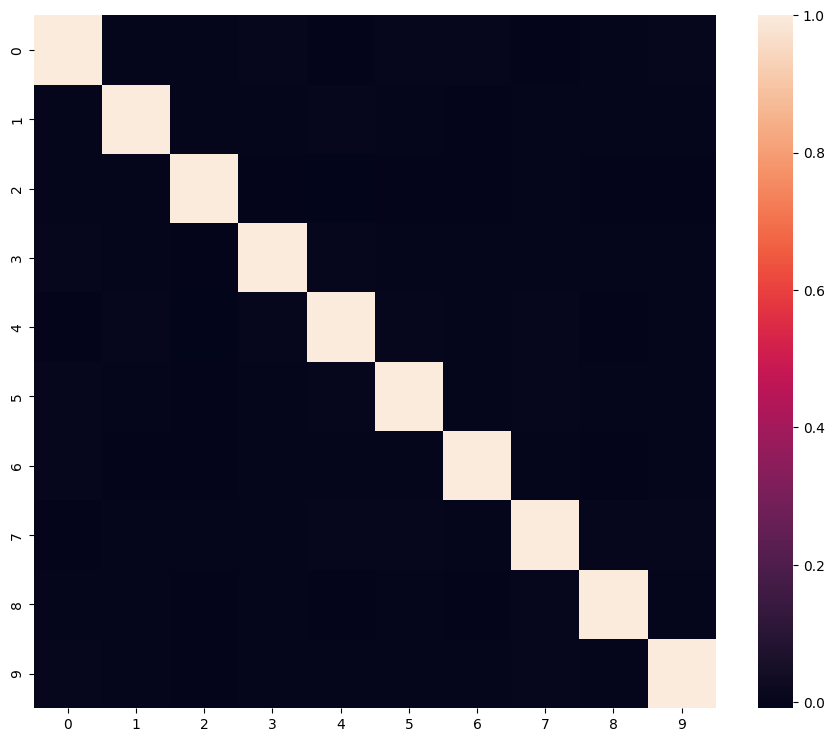

In [27]:
# validation results
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import palettable

plt.figure(figsize=(11, 9),dpi=100)
sns.heatmap(data=corr_mean,
           )

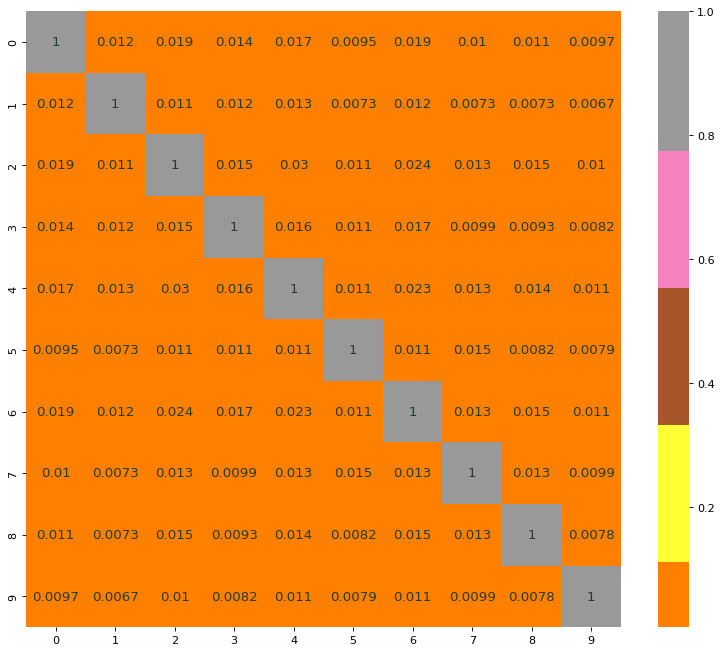

In [28]:
plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    corr_abs_mean,
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

In [29]:
np.sum(corr_abs_mean)-10

1.1379501651972532

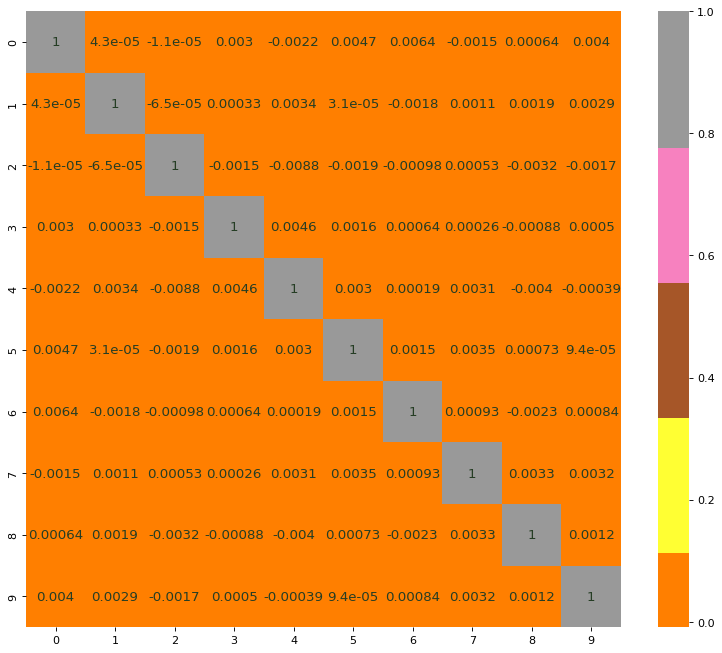

In [30]:
plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    corr_mean,
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

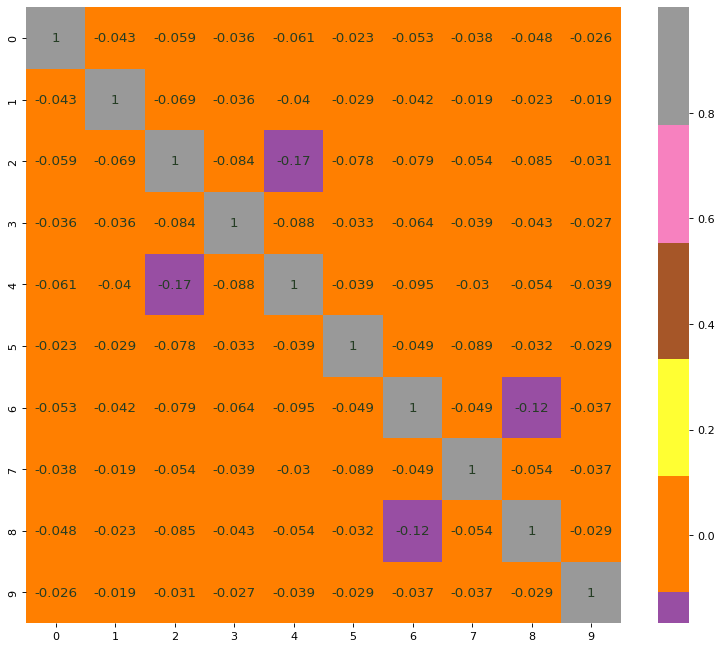

In [31]:
plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    corr_min,
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

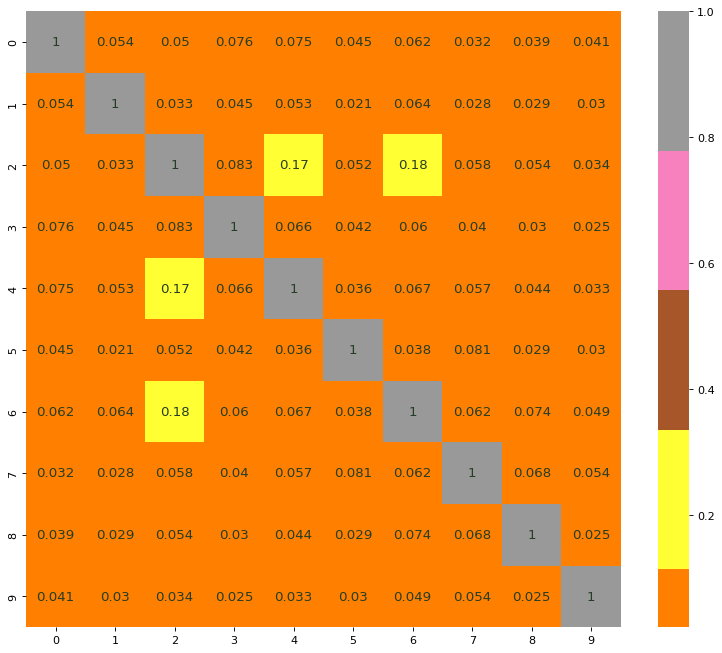

In [32]:
plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    corr_max,
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

In [33]:
np.save('FMNIST-normal-acc-label'+str(LABEL)+'-repeat.npy',acc_record)
np.save('FMNIST-normal-radius-label'+str(LABEL)+'-repeat.npy',r_records)
np.save('FMNIST-normal-corr-label'+str(LABEL)+'-repeat.npy',corr_whole)
# only need to save because we only train netD
torch.save(netD, 'Final_FMNIST_normal_NetD-label'+str(LABEL)+'-repeat.pth')
#torch.save(netV, 'MNIST_NetV-mode1-radius2-makeup.pth')
#torch.save(netG, 'MNIST_NetG-mode1-radius2-makeup.pth')

extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8307
SVD: 0.8222
NetG_fixDwith radius 0.16603612809651558 0.857
0.16603612809651558 0.857
-0.06093239612528123 1.3426048904657364 -4.899466417729855 5.4128035344183445


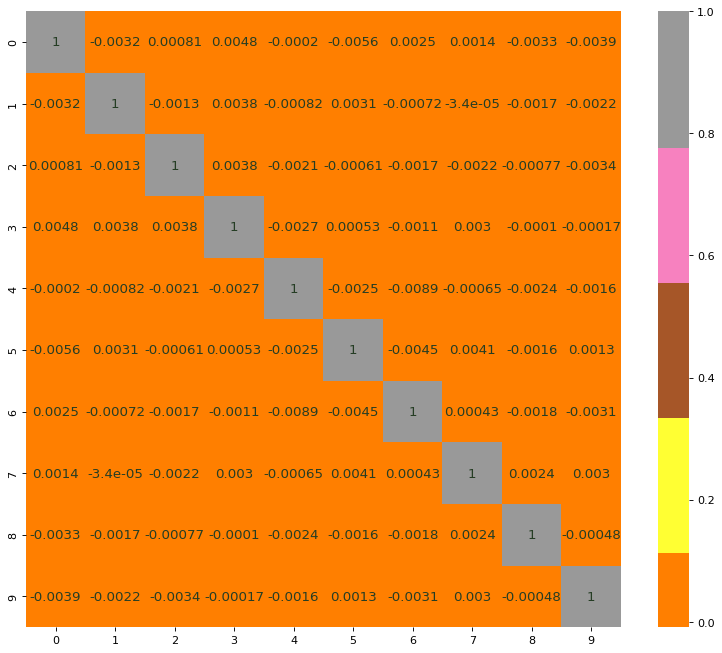

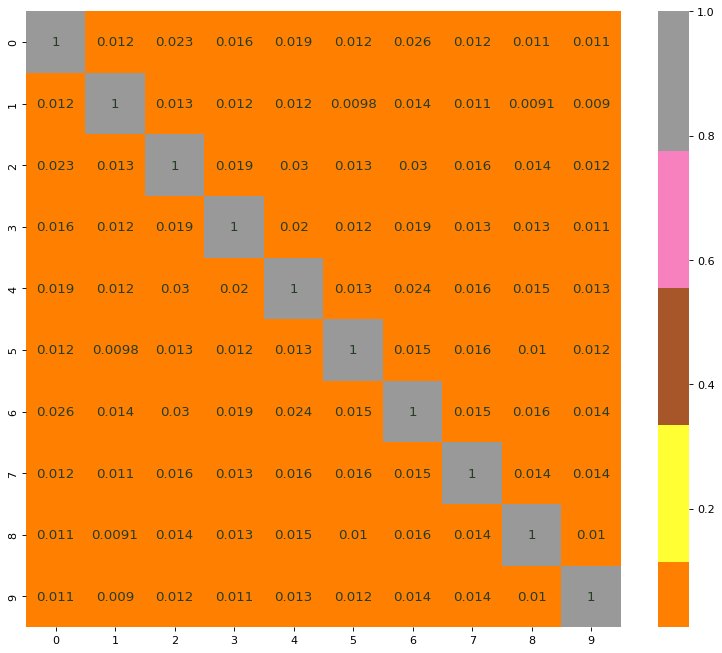

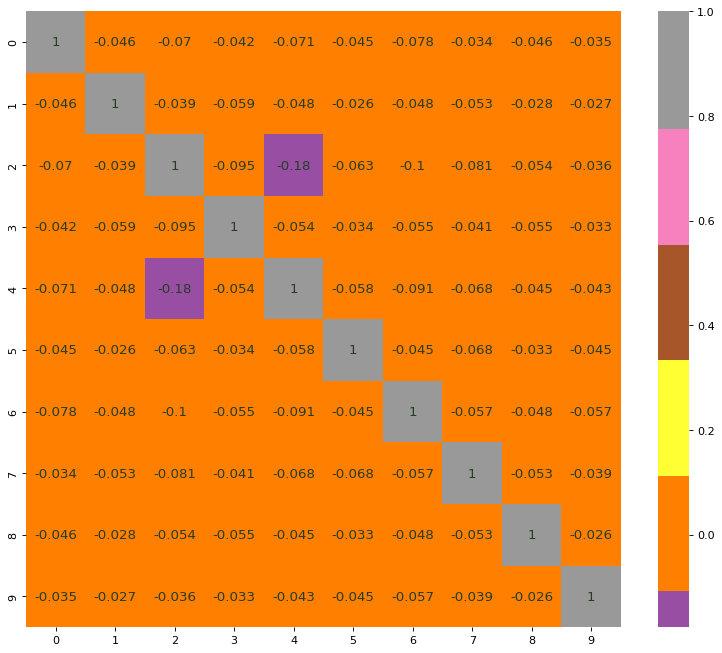

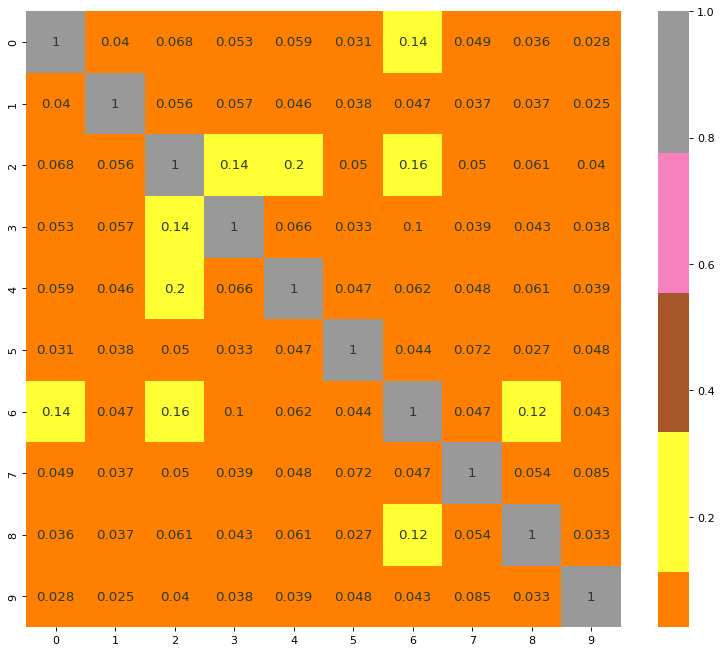

In [34]:
# test netG correlation and radius
test_r1,test_r2,test_corr,acc_val = gs_radius_val(radius1=0,radius2=100,netD=netD,real_cpu=real_cpu,real_label=real_label,tor=1e-5,n_dis=2,lam=0.618,mode=1)
print(test_r1,acc_val)
print(np.sum(test_corr[0:10])-10,np.sum(test_corr[10:20])-10,np.sum(test_corr[20:30])-10,np.sum(test_corr[30:40])-10)

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[0:10],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[10:20],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[20:30],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()


plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[30:40],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()



extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.8282
SVD: 0.8245
NetG_fixDwith radius 0.17364660207454147 0.8572
0.17364660207454147 0.8572
-0.054985543894872535 1.3432093691080809 -4.762498993426561 5.64612415805459


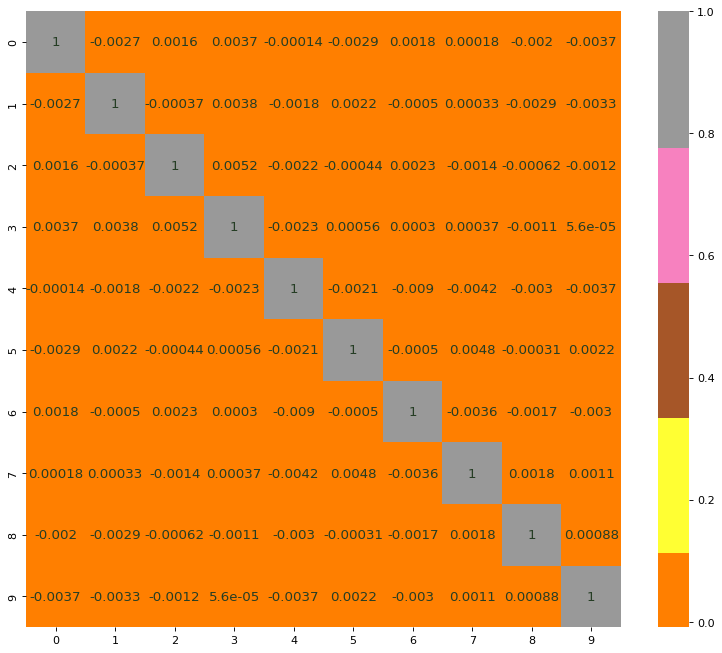

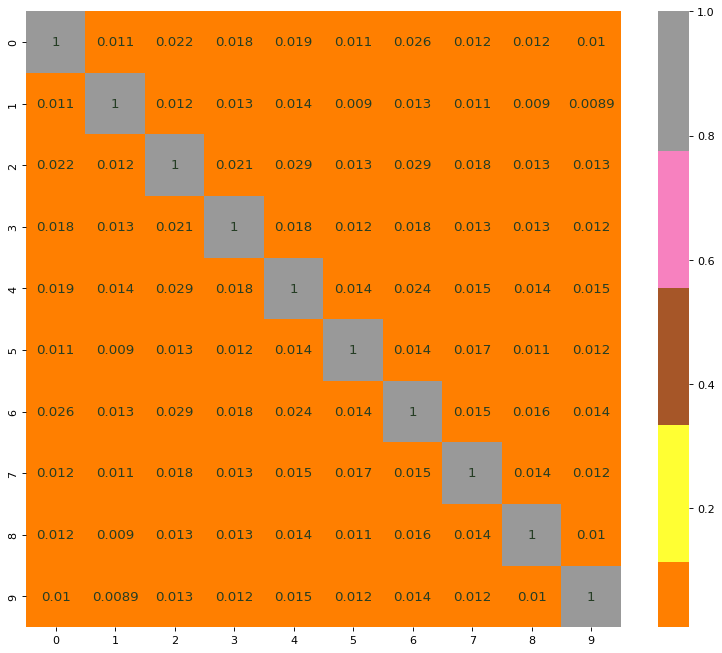

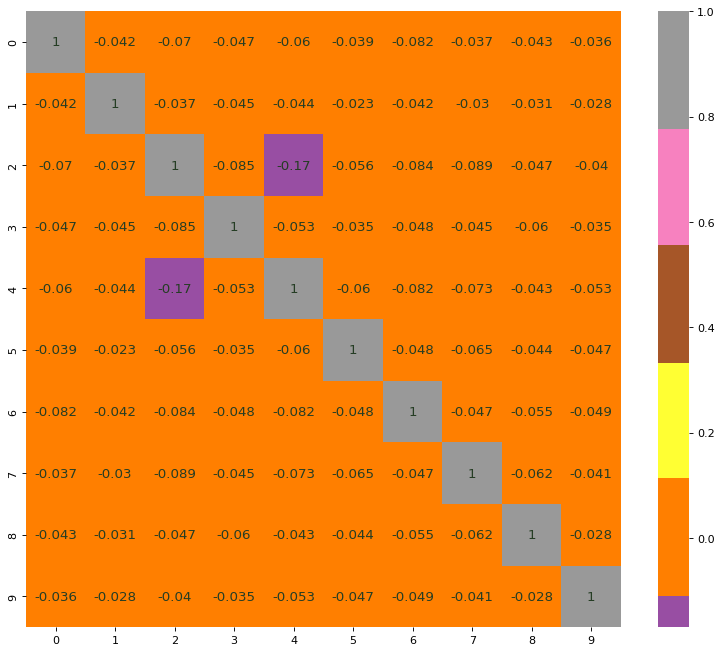

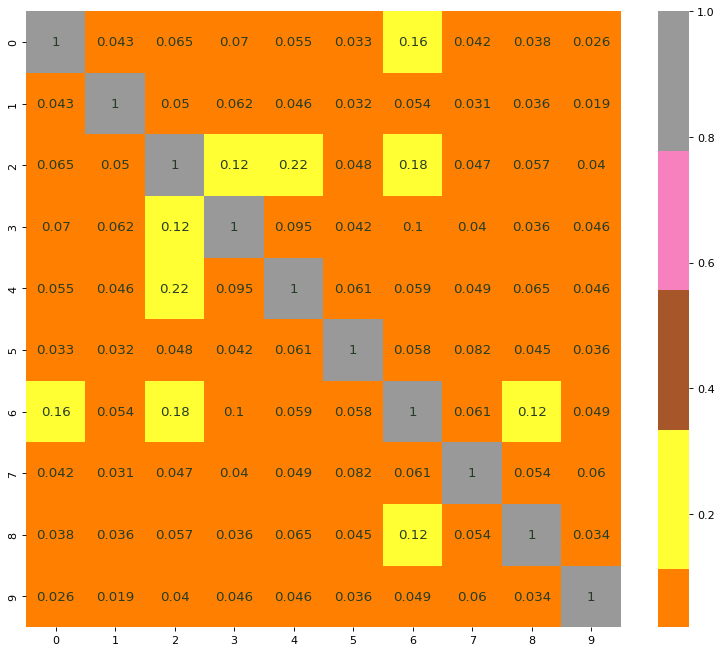

In [35]:
# test netG correlation and radius
test_r1,test_r2,test_corr,acc_val = gs_radius_val(radius1=0,radius2=100,netD=netD,real_cpu=real_cpu,real_label=real_label,tor=1e-5,n_dis=2,lam=0.618,mode=1)
print(test_r1,acc_val)
print(np.sum(test_corr[0:10])-10,np.sum(test_corr[10:20])-10,np.sum(test_corr[20:30])-10,np.sum(test_corr[30:40])-10)

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[0:10],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[10:20],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[20:30],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()


plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[30:40],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()



extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.8305
SVD: 0.8236
NetG_fixDwith radius 0.18591996642406716 0.8578
0.18591996642406716 0.8578
-0.07480858502094634 1.3424935173243284 -4.916028011590242 5.481930322945118


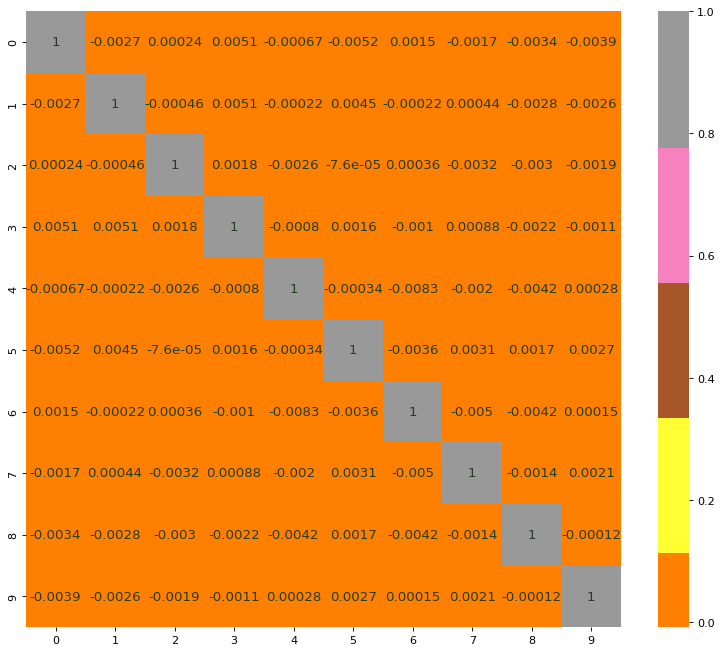

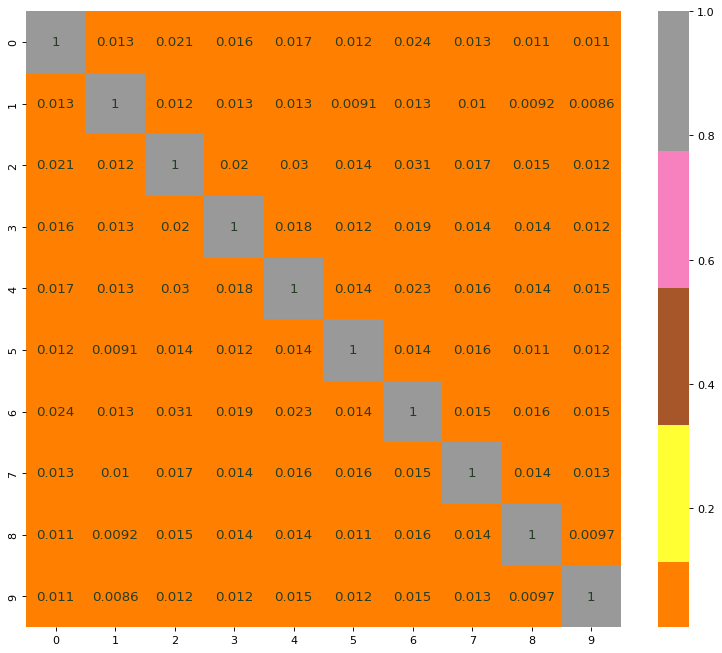

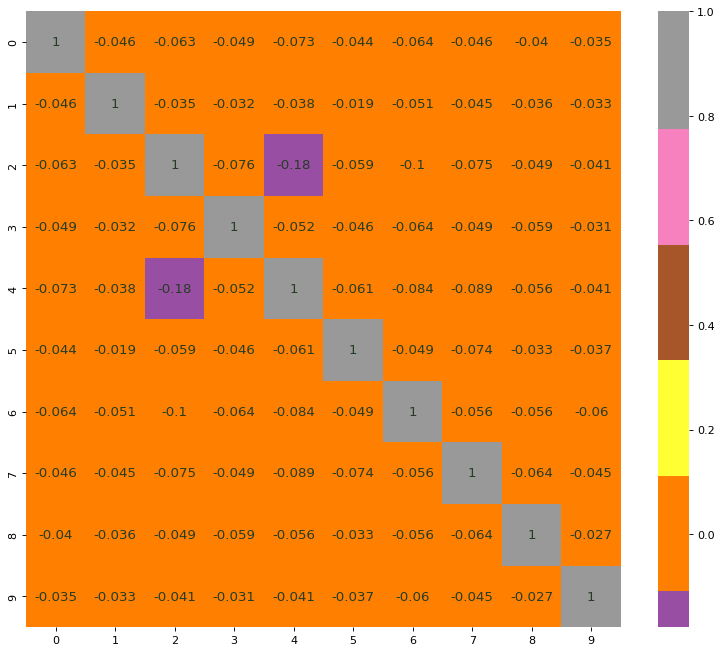

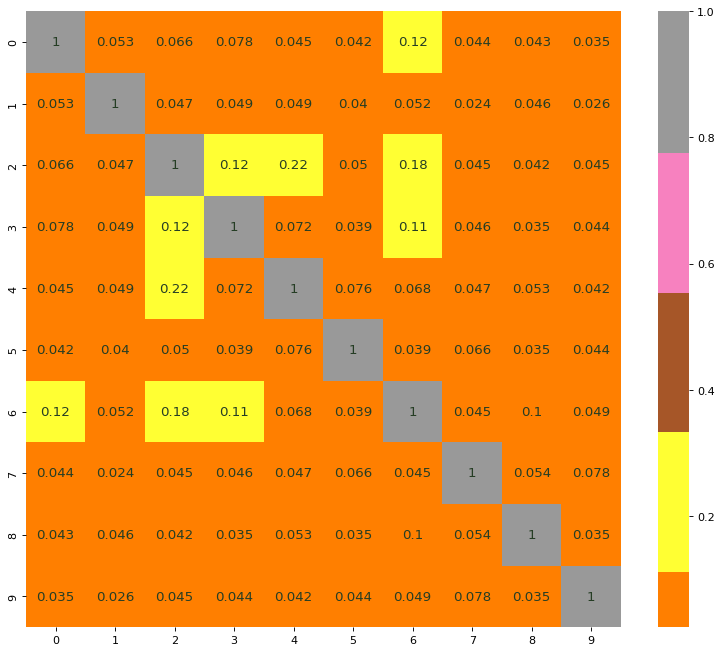

In [36]:
# test netG correlation and radius
test_r1,test_r2,test_corr,acc_val = gs_radius_val(radius1=0,radius2=100,netD=netD,real_cpu=real_cpu,real_label=real_label,tor=1e-5,n_dis=2,lam=0.618,mode=1)
print(test_r1,acc_val)
print(np.sum(test_corr[0:10])-10,np.sum(test_corr[10:20])-10,np.sum(test_corr[20:30])-10,np.sum(test_corr[30:40])-10)

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[0:10],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[10:20],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[20:30],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()


plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[30:40],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()



extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8306
SVD: 0.8251999999999999
NetG_fixDwith radius 0.20101714355501557 0.8573
0.20101714355501557 0.8573
-0.07088550009211758 1.3502805102616549 -4.892566040158272 5.521742917597294


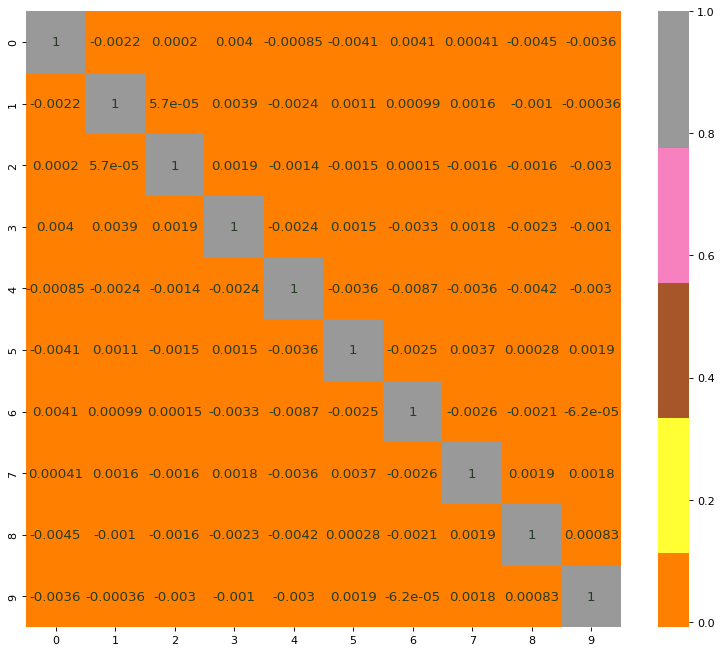

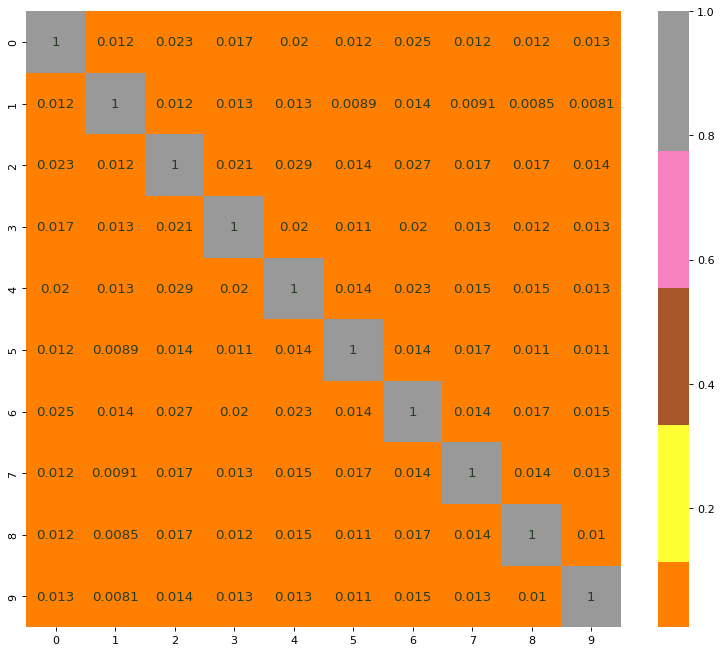

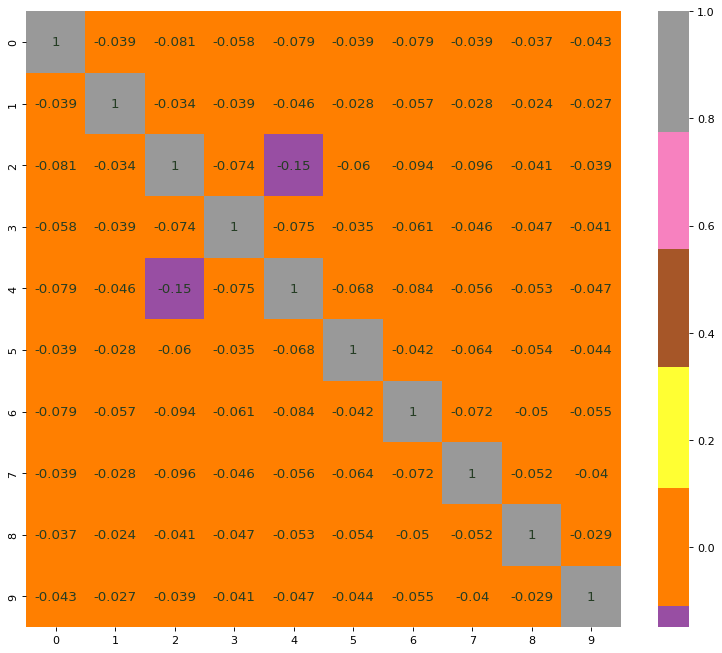

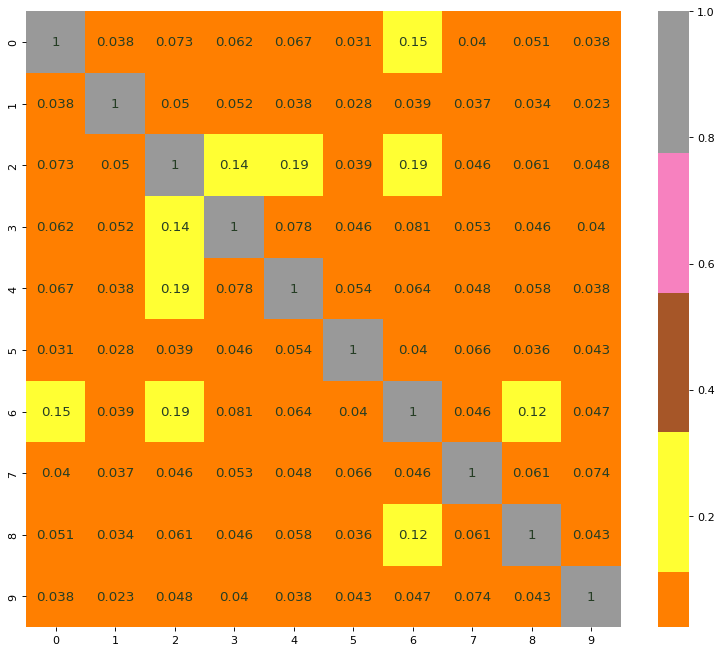

In [37]:
# test netG correlation and radius
test_r1,test_r2,test_corr,acc_val = gs_radius_val(radius1=0,radius2=100,netD=netD,real_cpu=real_cpu,real_label=real_label,tor=1e-5,n_dis=2,lam=0.618,mode=1)
print(test_r1,acc_val)
print(np.sum(test_corr[0:10])-10,np.sum(test_corr[10:20])-10,np.sum(test_corr[20:30])-10,np.sum(test_corr[30:40])-10)

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[0:10],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[10:20],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[20:30],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()


plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[30:40],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()



extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8311
SVD: 0.825
NetG_fixDwith radius 0.19181043520000646 0.8572
0.19181043520000646 0.8572
-0.0811495006273617 1.3323401529341936 -5.067352615296841 5.605381689965725


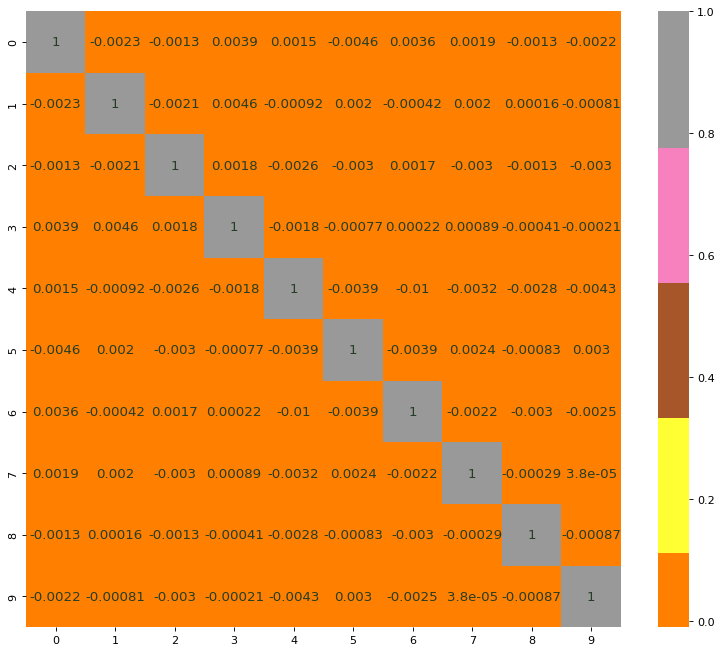

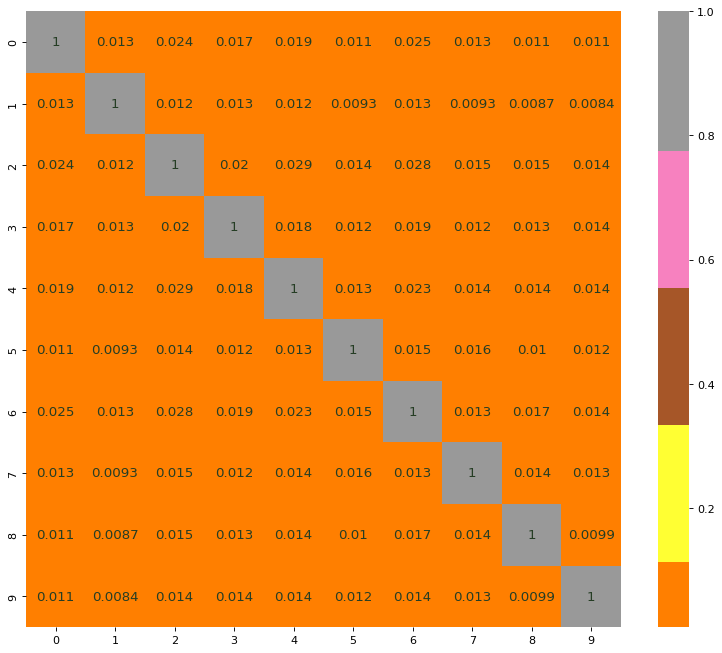

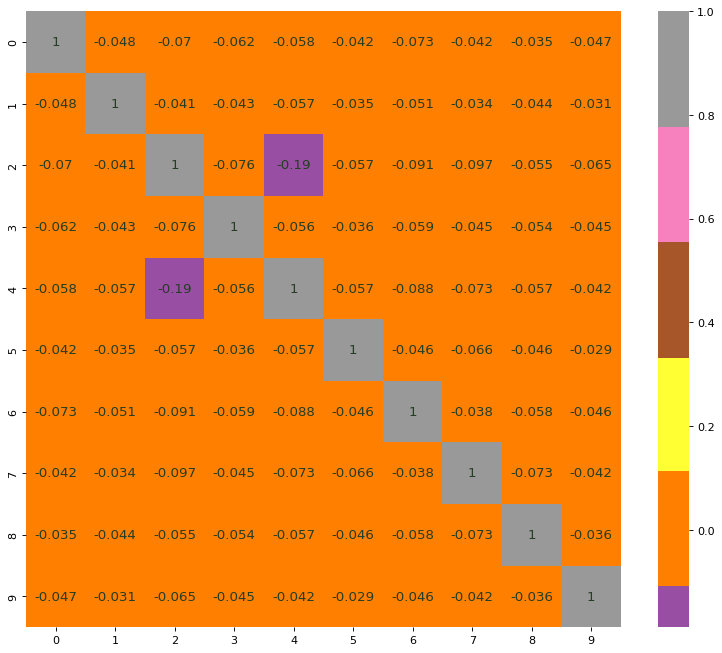

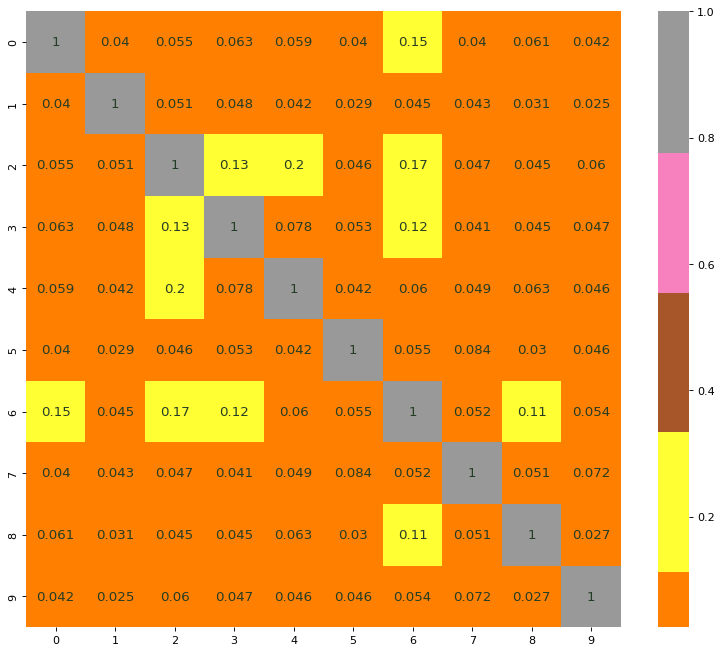

In [38]:
# test netG correlation and radius
test_r1,test_r2,test_corr,acc_val = gs_radius_val(radius1=0,radius2=100,netD=netD,real_cpu=real_cpu,real_label=real_label,tor=1e-5,n_dis=2,lam=0.618,mode=1)
print(test_r1,acc_val)
print(np.sum(test_corr[0:10])-10,np.sum(test_corr[10:20])-10,np.sum(test_corr[20:30])-10,np.sum(test_corr[30:40])-10)

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[0:10],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[10:20],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[20:30],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()


plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[30:40],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()



extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.8302
SVD: 0.8231999999999999
NetG_fixDwith radius 0.18194535125603703 0.8578
0.18194535125603703 0.8578
-0.050776642048731446 1.3344115447252989 -5.045305985957384 5.593848649412394


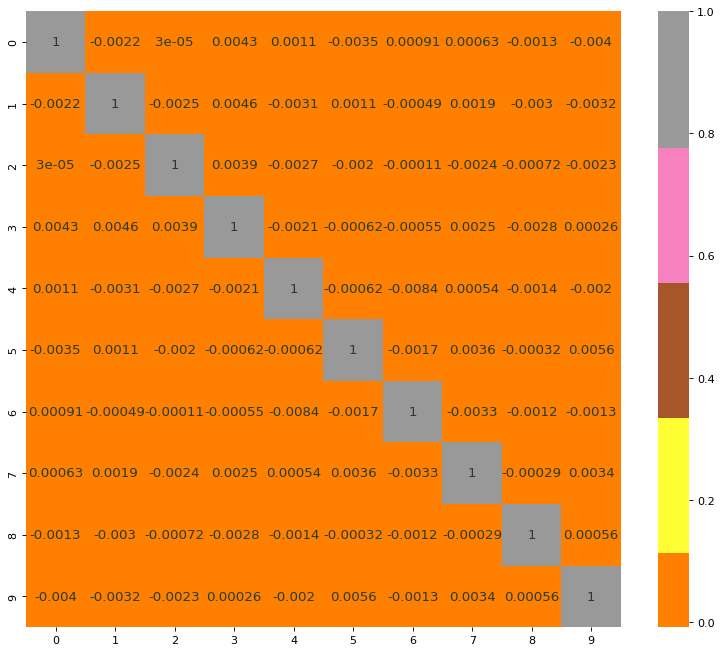

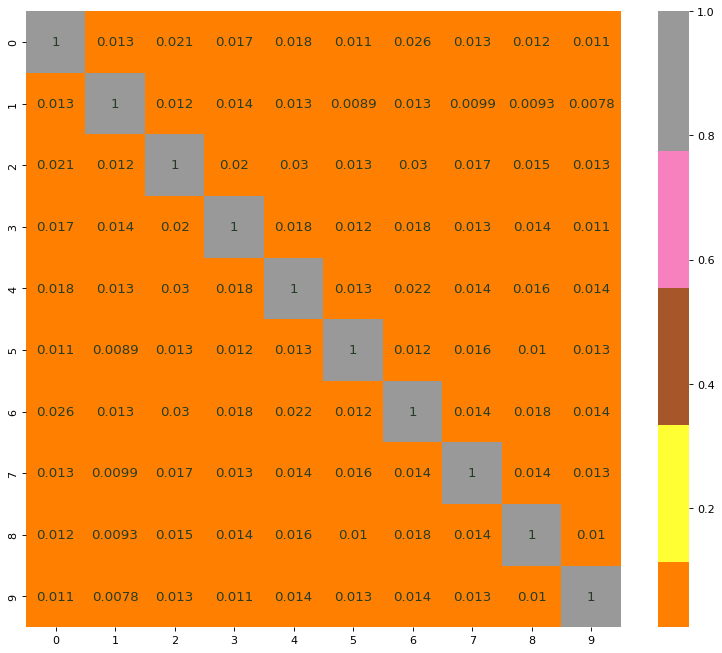

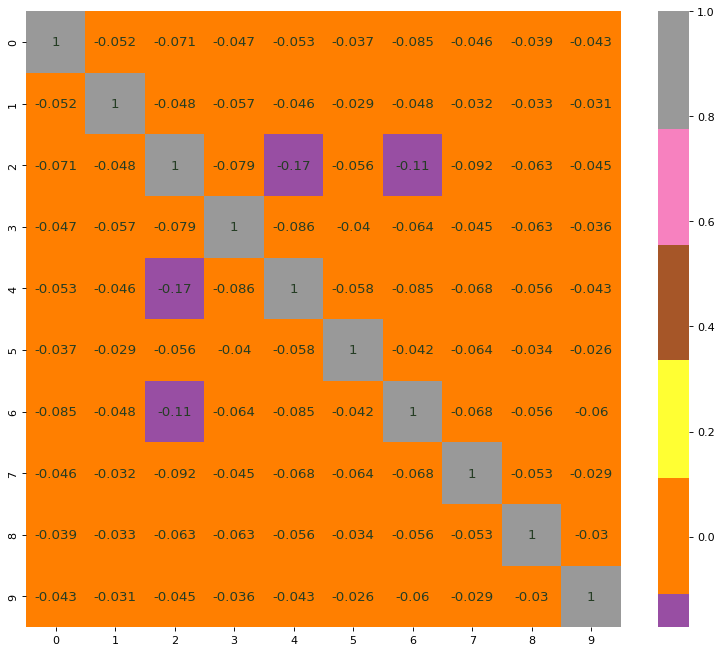

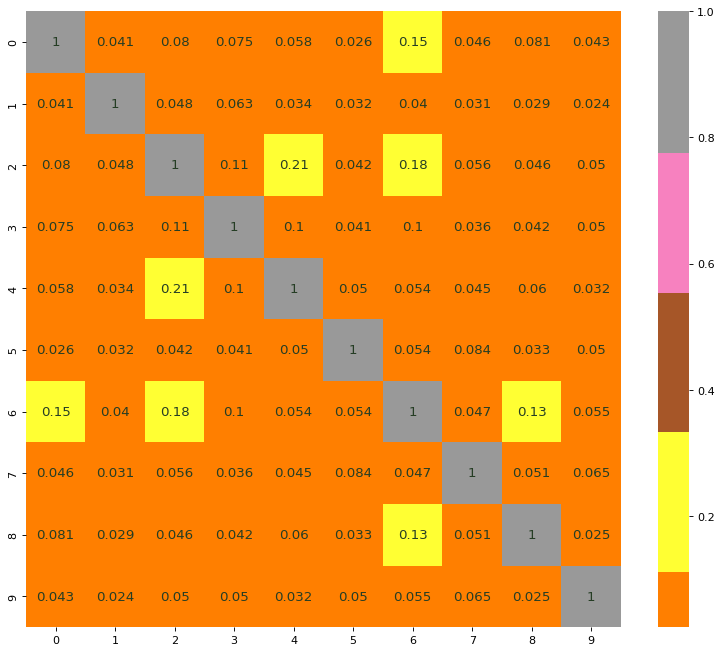

In [39]:
# test netG correlation and radius
test_r1,test_r2,test_corr,acc_val = gs_radius_val(radius1=0,radius2=100,netD=netD,real_cpu=real_cpu,real_label=real_label,tor=1e-5,n_dis=2,lam=0.618,mode=1)
print(test_r1,acc_val)
print(np.sum(test_corr[0:10])-10,np.sum(test_corr[10:20])-10,np.sum(test_corr[20:30])-10,np.sum(test_corr[30:40])-10)

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[0:10],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[10:20],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[20:30],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()


plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[30:40],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()



extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8311999999999999
SVD: 0.825
NetG_fixDwith radius 0.20726647125257203 0.8589
0.20726647125257203 0.8589
-0.031059448650921695 1.3453072812408209 -4.922892168164253 5.5211051851511


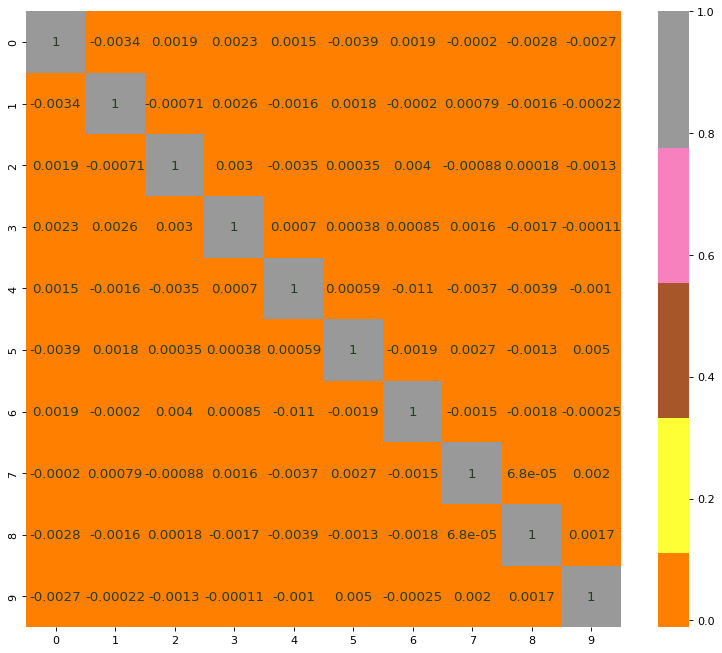

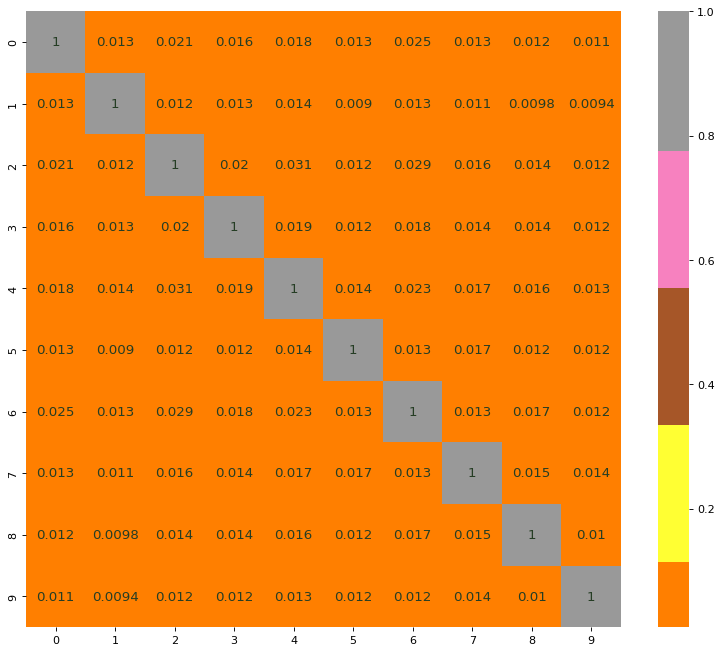

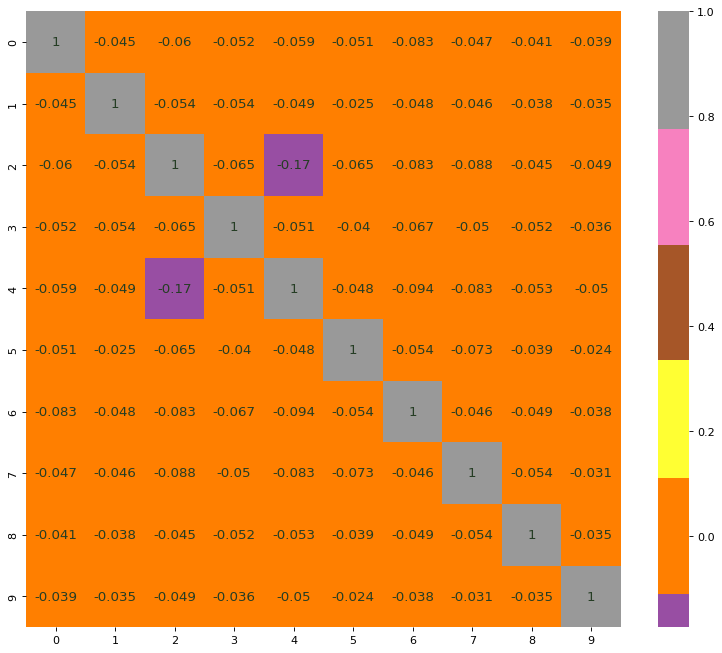

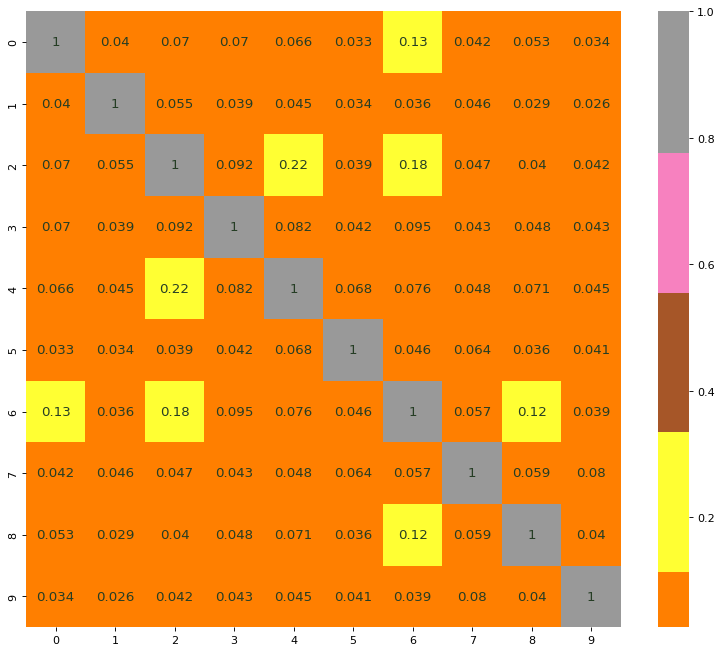

In [40]:
# test netG correlation and radius
test_r1,test_r2,test_corr,acc_val = gs_radius_val(radius1=0,radius2=100,netD=netD,real_cpu=real_cpu,real_label=real_label,tor=1e-5,n_dis=2,lam=0.618,mode=1)
print(test_r1,acc_val)
print(np.sum(test_corr[0:10])-10,np.sum(test_corr[10:20])-10,np.sum(test_corr[20:30])-10,np.sum(test_corr[30:40])-10)

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[0:10],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[10:20],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[20:30],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()


plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[30:40],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()



extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


----------------------------
Train_z, Test_z
PCA: 0.8283
SVD: 0.8238
NetG_fixDwith radius 0.20640570162923982 0.8574
0.20640570162923982 0.8574
-0.07319886449840851 1.3606614973396063 -5.104643538594246 5.517883725464344


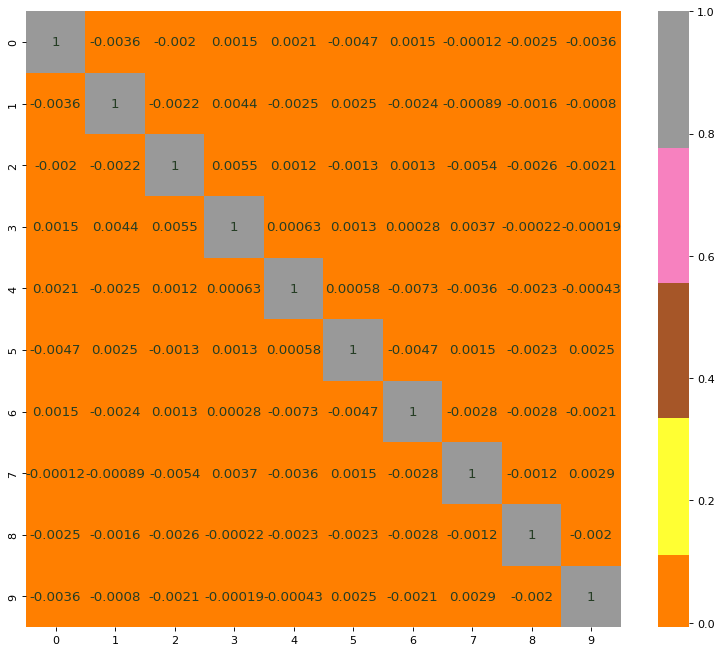

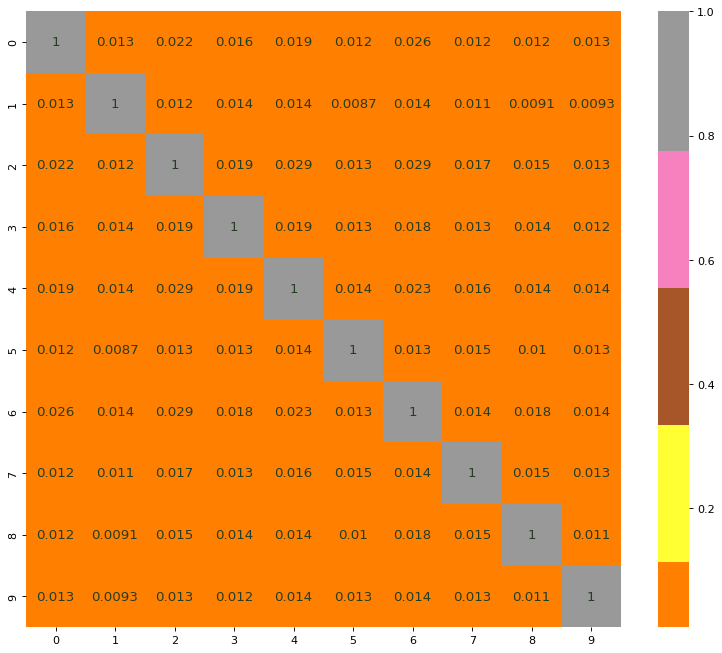

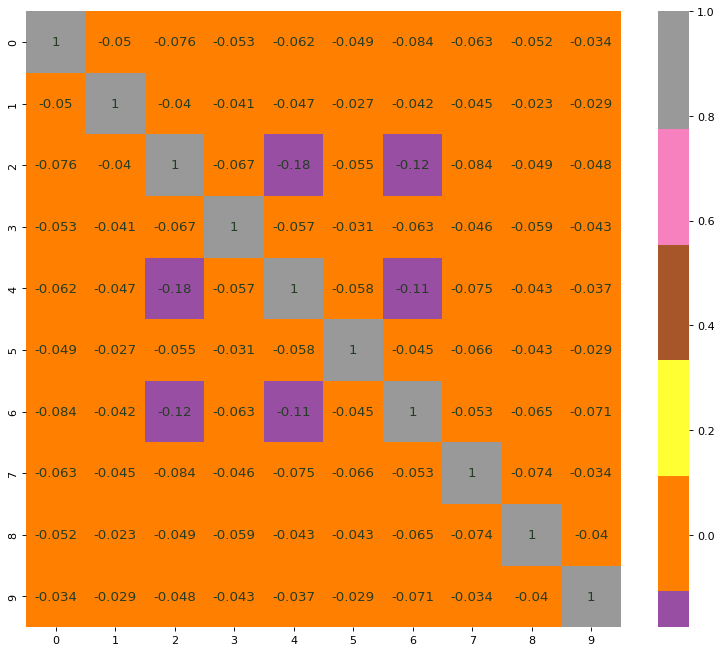

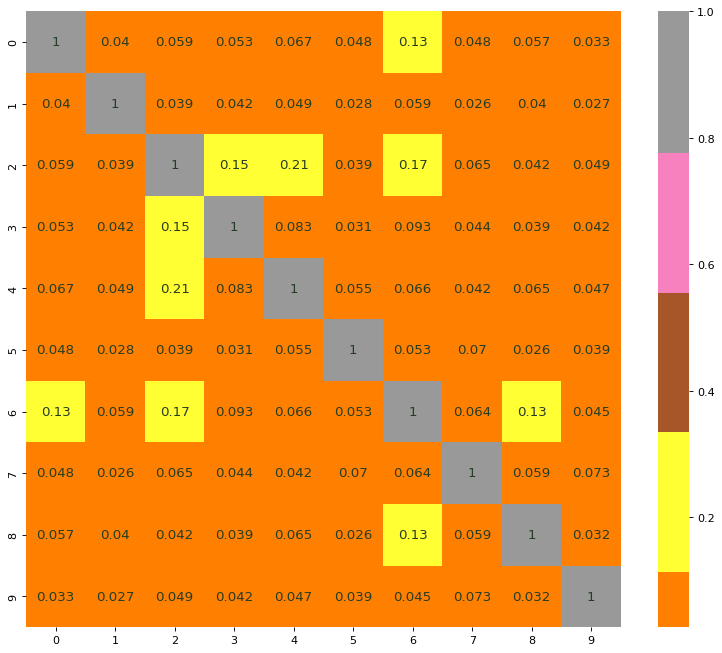

In [41]:
# test netG correlation and radius
test_r1,test_r2,test_corr,acc_val = gs_radius_val(radius1=0,radius2=100,netD=netD,real_cpu=real_cpu,real_label=real_label,tor=1e-5,n_dis=2,lam=0.618,mode=1)
print(test_r1,acc_val)
print(np.sum(test_corr[0:10])-10,np.sum(test_corr[10:20])-10,np.sum(test_corr[20:30])-10,np.sum(test_corr[30:40])-10)

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[0:10],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[10:20],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[20:30],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()


plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[30:40],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()



extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.8306
SVD: 0.8227
NetG_fixDwith radius 0.20482832886498895 0.8598
0.20482832886498895 0.8598
-0.05862402793718502 1.3437776193022728 -4.891428455710411 5.624052237719297


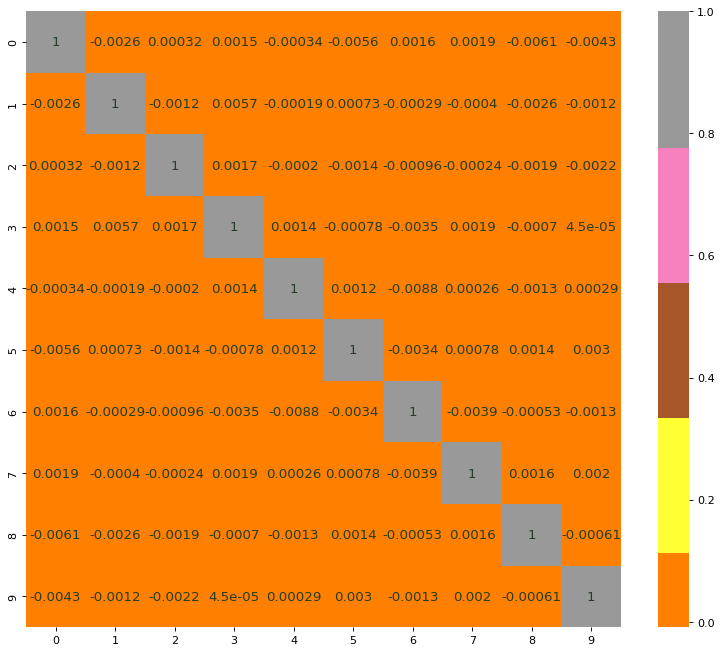

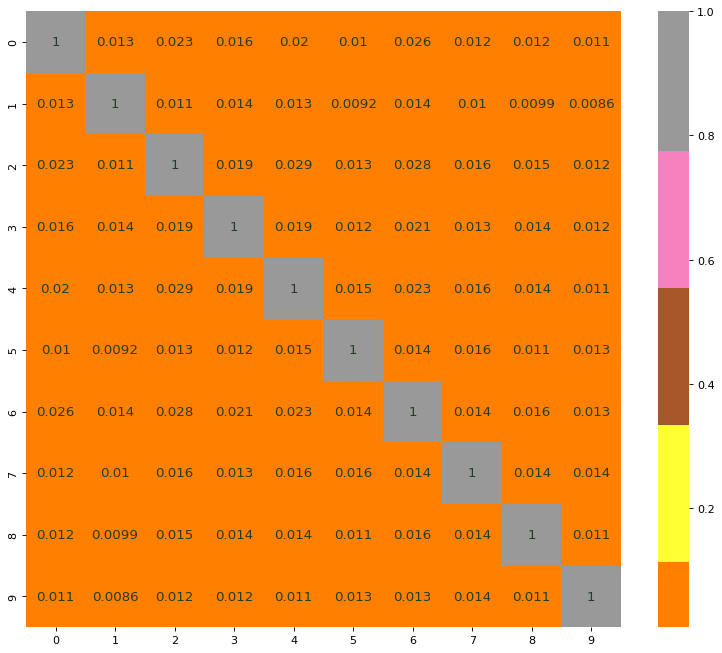

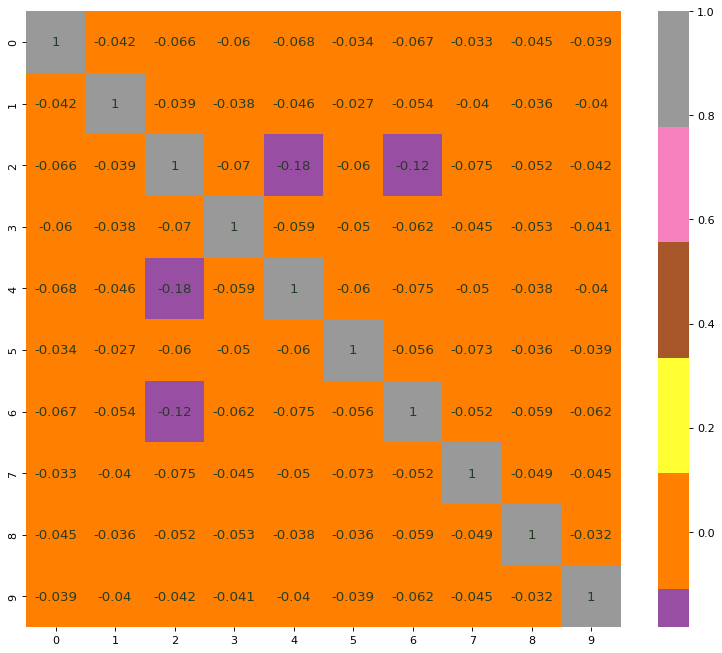

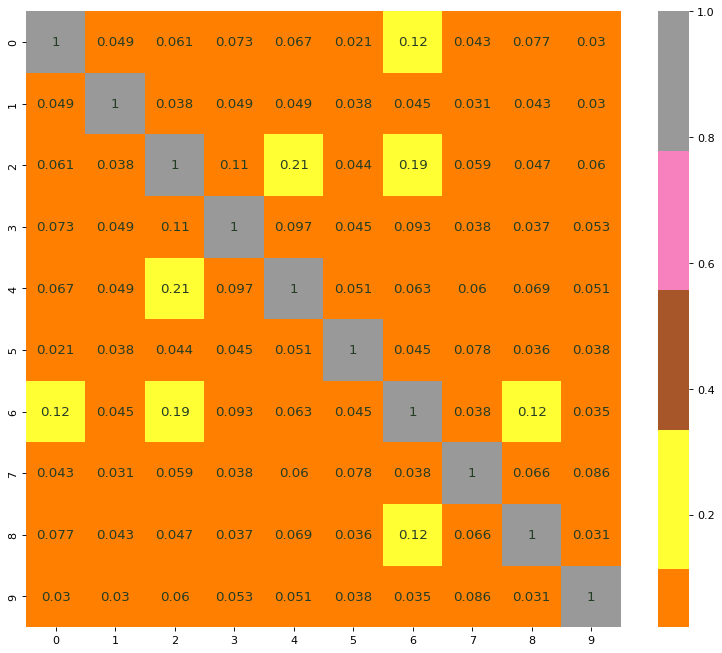

In [42]:
# test netG correlation and radius
test_r1,test_r2,test_corr,acc_val = gs_radius_val(radius1=0,radius2=100,netD=netD,real_cpu=real_cpu,real_label=real_label,tor=1e-5,n_dis=2,lam=0.618,mode=1)
print(test_r1,acc_val)
print(np.sum(test_corr[0:10])-10,np.sum(test_corr[10:20])-10,np.sum(test_corr[20:30])-10,np.sum(test_corr[30:40])-10)

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[0:10],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[10:20],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[20:30],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()


plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[30:40],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()



In [43]:
acc_record

array([[8.60000000e-01, 8.58075000e-01, 8.57845000e-01, 8.56490000e-01,
        8.51695000e-01, 8.31185000e-01, 6.82170000e-01, 3.29000000e-01,
        1.25410000e-01, 1.05785000e-01, 1.03810000e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.60000000e-01, 8.59100000e-01, 8.60300000e-01, 8.58300000e-01,
        8.54100000e-01, 8.37800000e-01, 7.43300000e-01, 4.22100000e-01,
        1.49300000e-01, 1.37400000e-01, 1.31400000e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.60000000e-01, 8.56800000e-01, 8.56400000e-01, 8.54300000e-01,
        8.49200000e-01, 8.23800000e-01, 5.62500000e-01, 2.42400000e-01,
        9.08000000e-02, 7.98000000e-02, 8.26000000e-02, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.0000